# Analyzing the business metrics of Yandex.Afisha

There is a service that helps users find out about events like movie showings, exhibitions, gigs, etc. and buy tickets.
    
We have:
* Server logs with data on Yandex.Afisha visits from June 2017 through May 2018
* Dump file with all orders for the period
* Marketing expenses statistics

The purpose of the study is to explore:
* How people use the product
* When they start to buy
* How much money each customer brings
* When they pay off

The Work Plan:

<a href='#section1'>1. Getting the data and preparing it for the analysis</a>

* <a href='#section1.1'>1.1. Downloading a small portion of data</a>

* <a href='#section1.2'>1.2. Downloading data with the correct data types and study the general information.</a>

* <a href='#section1.3'>1.3. Data Preprocessing </a>

* <a href='#section1.4'>1.4. Main Conclusions </a>

<a href='#section2'>2. Calculating Metrics</a>

* <a href='#section2.1'>2.1 Product metrics</a>

* <a href='#section2.2'>2.2 Sales metrics</a>

* <a href='#section2.3'>2.3 Marketing metrics</a>

* <a href='#section2.4'>2.4 Main Conclusions</a>

<a href='#section3'>3. Marketing investment recommendations</a>

## 1. Getting the data and preparing it for the analysis
<a id='section1'></a>

### 1.1 Downloading a small portion of data 
<a id='section1.1'></a>

In [1]:
#importing of libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib import gridspec
import warnings
warnings.filterwarnings('ignore')

#some global constats for formatting the output string
BOLD = '\033[1m'
END = '\033[0m'

#function to get a filename from the path
def get_short_name(path):
    return path.split('/')[-1:][0]
 
#function to get the number of rows in a file without headers 
def get_rows_num(file_name):
    with open(file_name) as f:
        return sum(1 for line in f) - 1


#function to check if there are dates in a series
#formats: 2 or 4 digits for the year at the end or at the beginning,
#2 digits for the day at the end or at the beginning
#and 2 digits for the month in the middlie,
#separated by "-", "/", "\" or "."
def if_date_in_series(series):
    return series.str\
        .match('\d{2,4}(-|\/|\\|\.| )\d{2}(-|\/|\\|\.| )\d{2,4}').all()

#function to get beginnings of the week by dates 
def get_start_of_week(series):
    return series - pd.to_timedelta(series.dt.dayofweek, unit='d')

#function to calculate the upper border of outliers
def outliers_border(series):
    Q1 = series.quantile(0.25) 
    Q3 = series.quantile(0.75) 
    IQR = Q3 - Q1 
    return Q3 + 1.5 * IQR

In [2]:
#Let's load a small portion of data, look at the data types and estimate the amount of memory required.
#creating a list of file paths
file_names = ['/datasets/visits_log_us.csv',
              '/datasets/orders_log_us.csv',
              '/datasets/costs_us.csv']
dfs = []
for file_name in file_names:
    #loading only 500 rows of data
    df = pd.read_csv(file_name, nrows=500)
    dfs.append(df)
    
    name = get_short_name(file_name)
    #getting the number of rows in a data file
    rows_num = get_rows_num(file_name)
    
    #estimating of required memory by 500 data rows
    memory_required = rows_num / 500 * df.memory_usage(index=True, deep=True).sum()
    
    #looking at the data's general information by 500 data rows
    print(BOLD + "DataFrame info of 500 first lines from '" 
          + name + "' file" + END)
    print(df.info(memory_usage='deep'))
    
    #printing the number of rows in a file and an amount estimate of memory required for them
    print(BOLD + "File '" + name + "' contains " + str(rows_num)
              + " rows and requires about " 
              + str(round(memory_required/1024/1024, 2))
              + " MB of memory" + END)
    print()

DataFrame info of 500 first lines from 'visits_log_us.csv' file
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
Device       500 non-null object
End Ts       500 non-null object
Source Id    500 non-null int64
Start Ts     500 non-null object
Uid          500 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 113.1 KB
None
File 'visits_log_us.csv' contains 359400 rows and requires about 79.42 MB of memory

DataFrame info of 500 first lines from 'orders_log_us.csv' file
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
Buy Ts     500 non-null object
Revenue    500 non-null float64
Uid        500 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 45.0 KB
None
File 'orders_log_us.csv' contains 50415 rows and requires about 4.44 MB of memory

DataFrame info of 500 first lines from 'costs_us.csv' file
<class 'pandas.core.frame.DataFrame'>
RangeI

*The `'visits_log_us.csv'` file contains __359,400 rows__ and requires about __80 MB__ of memory. There are 5 columns in total, 3 of which are the Object data type. According to the data description the `'Device'` column contains information about the type of user's device (there should not be many of them) and `'End Ts'` and `'Start Ts'` columns contain dates.*

*The `'orders_log_us.csv'` file contains __50,415 rows__ and requires about __4.5 MB__ of memory. There are 3 columns in total, one column of which is the Object data type. According to the data description it contains dates.*

*The `'costs_us.csv'` file contains only __2,542 rows__ and requires about __200 KB__ of memory. There are 3 columns in total, one column of which is the Object data type. According to the data description it contains dates.*

*After checking the contents of the columns that are of object type, we can load the complete data with the corresponding types.*

In [3]:
#checking the contents of the columns that are of object type
print(BOLD + "Number of unique values in 'Device' column in '" 
      + get_short_name(file_names[0]) + "': " + END
      + str(dfs[0].Device.nunique()))
print(dfs[0].Device.unique())
print()

date_columns = [['Start Ts', 'End Ts'], ['Buy Ts'], ['dt']]
for (name, df, cols) in zip(file_names, dfs, date_columns):
    for col in cols:
        print(BOLD + "'" + col + "' column in '" + get_short_name(name) 
                  + "' contains date:" + END)
        print(if_date_in_series(df[col]))
        print()

Number of unique values in 'Device' column in 'visits_log_us.csv': 2
['touch' 'desktop']

'Start Ts' column in 'visits_log_us.csv' contains date:
True

'End Ts' column in 'visits_log_us.csv' contains date:
True

'Buy Ts' column in 'orders_log_us.csv' contains date:
True

'dt' column in 'costs_us.csv' contains date:
True



*We can load complete data with a category type for the `'Device'` column in `'visits_log_us.csv'` and a datetime type for `'Start Ts'`, `'End Ts'`, `'Buy Ts'` and `'dt'` columns in the corresponding tables.*

### 1.2 Downloading data with the correct data types and study the general information.
<a id='section1.2'></a>

In [4]:
#reading files that contain logs and marketing data 
visits = pd.read_csv('/datasets/visits_log_us.csv',    
                      dtype={'Device': 'category'},
                      parse_dates=['Start Ts', 'End Ts'])  

orders = pd.read_csv('/datasets/orders_log_us.csv',     
                      parse_dates=['Buy Ts'])  

costs = pd.read_csv('/datasets/costs_us.csv',     
                      parse_dates=['dt'])

#creating the list of tables and their descriptions
tables = [visits, orders, costs]
descriptions = ['data on website visits', 'data on orders',
                    'data on marketing expenses']


for i, (table, description) in enumerate(zip(tables, descriptions)):
    #looking at the data's general information.
    print(BOLD + 'General inforamation about the tables contains ' 
          + description + ':' + END)
    table.info(memory_usage='deep')
    print()
    
    #looking at the first few rows in a table
    print(BOLD + 'The first rows of the table contains ' 
      + description + ':' + END)
    display(table.head())
    print()

General inforamation about the tables contains data on website visits:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null category
End Ts       359400 non-null datetime64[ns]
Source Id    359400 non-null int64
Start Ts     359400 non-null datetime64[ns]
Uid          359400 non-null uint64
dtypes: category(1), datetime64[ns](2), int64(1), uint64(1)
memory usage: 11.3 MB

The first rows of the table contains data on website visits:


,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168



General inforamation about the tables contains data on orders:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null datetime64[ns]
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB

The first rows of the table contains data on orders:


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450



General inforamation about the tables contains data on marketing expenses:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB

The first rows of the table contains data on marketing expenses:


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


*The dataset contains information about __359,400 sessions of site visitors who made 50,415 purchases__ and __marketing expenses__ on the ad source the user came from.* 

*There are __no null values__ in the tables.*

*For the `'Source Id'` column in the table with log data and the `'source_id'` column in the table with market expenses __int64__ is used. It seems excessive. According the data description the columns contain the identifier of the ad source.*

*It looks like __the start and end times of the session__, as well as __the purchase time__, have been __rounded to the minutes__.*

In [5]:
#Let's look at the values that take numerical features 

#function to find the minimum positive number in a series. 
def positive_min(series):
    return min([x for x in series.dropna() if x > 0])

print(BOLD + 'Numerical features' + END)
#looking at the values that take numerical features 
for table, col, description in zip(tables[-2:], ['Revenue', 'costs'], descriptions[-2:]):
    print(BOLD + "The '" + col + "' column in the table containing " + description + ':' + END)
    display(round(table[[col]].describe(), 2).T)
    print()

#Let's look at the values that take categorical features 
print(BOLD + 'Categorical features' + END)
for table, cols, descr in zip([visits, costs], [['Device','Source Id'], ['source_id']],
                              ['data on website visits', 'data on marketing expenses']):
    print(BOLD + "The columns with categorical values in the table containing " + descr + ':' + END)
    pd.set_option('display.max_colwidth', -1)
    display(table[cols].agg(['unique', 'nunique']).T)
    print()
    
#Let's look at date range in the dataset
print(BOLD + 'Features containing dates' + END)
print(BOLD + 'Date range in the dataset:' + END)
for table, date_col in zip(tables, date_columns):
    display(table[date_col].agg(['min', 'max']))

Numerical features
The 'Revenue' column in the table containing data on orders:


,count,mean,std,min,25%,50%,75%,max
Revenue,50415.0,5.0,21.82,0.0,1.22,2.5,4.89,2633.28



The 'costs' column in the table containing data on marketing expenses:


,count,mean,std,min,25%,50%,75%,max
costs,2542.0,129.48,156.3,0.54,21.94,77.3,170.06,1788.28



Categorical features
The columns with categorical values in the table containing data on website visits:


,unique,nunique
Device,"[touch, desktop] Categories (2, object): [touch, desktop]",2
Source Id,"[4, 2, 5, 9, 3, 1, 10, 7, 6]",9



The columns with categorical values in the table containing data on marketing expenses:


,unique,nunique
source_id,"[1, 2, 3, 4, 5, 9, 10]",7



Features containing dates
Date range in the dataset:


,Start Ts,End Ts
min,2017-06-01 00:01:00,2017-06-01 00:02:00
max,2018-05-31 23:59:00,2018-06-01 01:26:00


,Buy Ts
min,2017-06-01 00:10:00
max,2018-06-01 00:02:00


,dt
min,2017-06-01
max,2018-05-31


*The dataset containds information about sessions and marketing info __from June 1, 2017 to June 1, 2018__.* 

*__Visitors spend on average \\$ 2.5 per an order__. There are some purchases with __zero `'Revenue'` value__. They __look like missing values.__ The maximum purchase was \\$ 2,633.28, which is 1,000 times the average purchase. It is worth checking the correctness of this abnormal value.*

*Marketing costs were minimum \\$ 0.54 and maximum $ 1,788.28 per day on ad source. __On average, an ad source requires about \\$ 80 per day__.*

*There are __9 ad sources__ among user sessions, only 7 of them require direct marketing spend (sources 6 and 7 are not in the table containing data on marketing expenses). 
So, the values for the `'Source Id'` and `'source_id'` columns are such that the type __int8__ would be enough for them.*

In [6]:
#Let's look at excessive June 1, 2018
print(BOLD + 'Sessions after May 2018:' + END)
#display(visits[visits['end_datetime']>=('2018-06-01')])
display(visits[visits['End Ts']>=('2018-06-01')])

print(BOLD + 'Orders after May 2018:' + END)
#orders[orders['buy_datetime']>=('2018-06-01')]
display(orders[orders['Buy Ts']>=('2018-06-01')])

Sessions after May 2018:


,Device,End Ts,Source Id,Start Ts,Uid
2330,desktop,2018-06-01 00:05:00,2,2018-05-31 23:30:00,5300693976971713685
43215,desktop,2018-06-01 00:13:00,4,2018-05-31 23:46:00,12296626599487328624
46667,desktop,2018-06-01 00:13:00,5,2018-05-31 23:48:00,1107134732939577311
154728,desktop,2018-06-01 00:09:00,2,2018-05-31 22:52:00,12484396335714047199
198329,desktop,2018-06-01 00:11:00,3,2018-05-31 23:59:00,3720373600909378583
216791,touch,2018-06-01 00:06:00,5,2018-05-31 23:45:00,9951896961656595558
263781,desktop,2018-06-01 00:25:00,1,2018-05-31 23:59:00,4906562732540547408
269213,touch,2018-06-01 00:12:00,10,2018-05-31 23:59:00,10723414689244282024
288563,touch,2018-06-01 00:01:00,4,2018-05-31 23:37:00,1094281763368510391
299620,desktop,2018-06-01 00:04:00,4,2018-05-31 23:59:00,83872787173869366


Orders after May 2018:


,Buy Ts,Revenue,Uid
50414,2018-06-01 00:02:00,3.42,83872787173869366


*We have 12 users whose sessions started on May 31, 2018 and ended on June 1, 2018. One of them managed to make a purchase on June 1.*

We can exclude this purchase from consideration for further analysis.

In [7]:
#removing purchases after May, 2018
orders = orders[orders['Buy Ts']<('2018-06-01')]

Date distribution of abnormal 'Revenue' values:


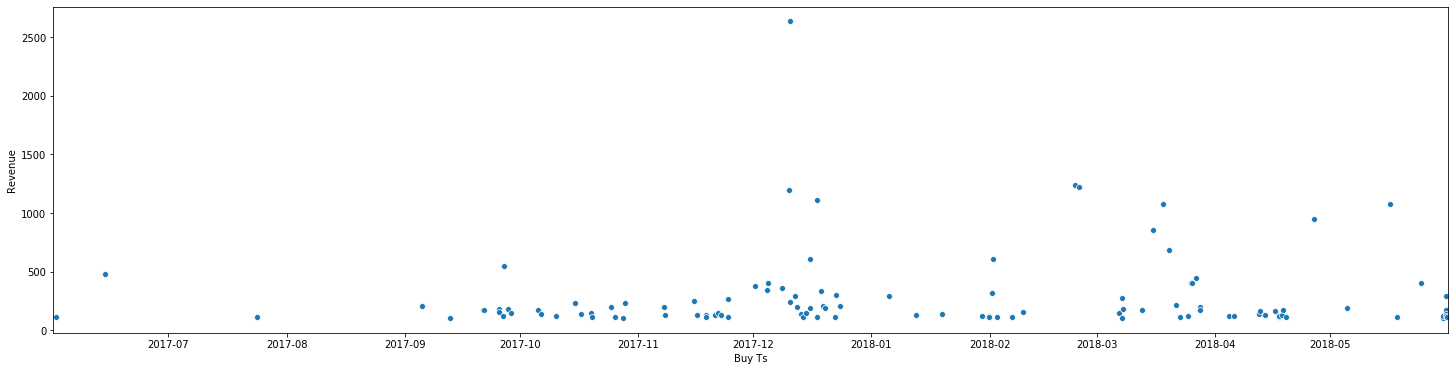

Date distribution of abnormal 'cost' values:


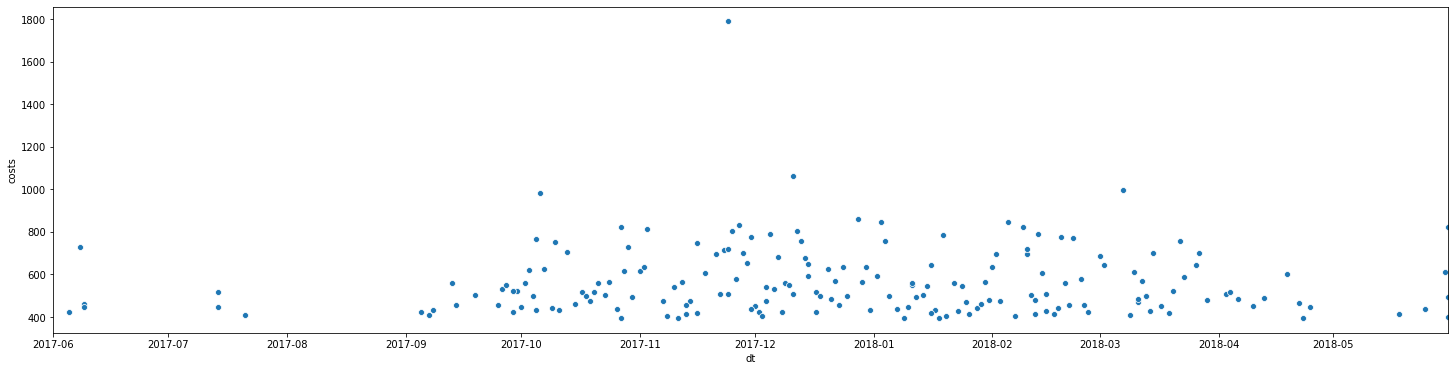

In [8]:
#Let's look at abnormal values of 'Revenue' and 'cost' features
print(BOLD + "Date distribution of abnormal 'Revenue' values:" + END)
fig, ax = plt.subplots(figsize=(25, 6))
sns.scatterplot(data=orders[orders.Revenue>10*outliers_border(orders.Revenue)],
                x='Buy Ts', y='Revenue', ax=ax)
ax.set(xlim = orders['Buy Ts'].agg(['min', 'max']).values);
#ax.set(xlim = ('2017-05-31', '2018-06-02'));
plt.show()

print(BOLD + "Date distribution of abnormal 'cost' values:" + END)
fig, ax = plt.subplots(figsize=(25, 6))
sns.scatterplot(data=costs[costs.costs>outliers_border(costs.costs)],
                x='dt', y='costs', ax=ax)
ax.set(xlim = costs['dt'].agg(['min', 'max']).values);
#ax.set(xlim = ('2017-05-31', '2018-06-02'));

*Abnormal values of revenue per order and costs are distributed more or less evenly over time, with the exception of the summer months. One value of revenue in December stands out from the rest of the points. It is worth checking the correctness of this value. One 'costs' point also stands out in November. It's worth checking it out as well.*

In [9]:
#Let's look at amount of missing value in 'Revenue' column
print(BOLD + "The number of zero values in 'Revenue' column:" + END, len(orders[orders.Revenue==0]))

The number of zero values in 'Revenue' column: 51


*We can consider zero values of purchases as missing values. The amount is small, so we can drop them.*

In [10]:
#Let's check if the time contains seconds
for table, cols in zip(tables, date_columns):
    for col in cols:
        print(BOLD + "Dates in the '" + col + "' column contain seconds:" + END)
        print((table[col].map(lambda x: x.second)>0).any())
        print()

Dates in the 'Start Ts' column contain seconds:
False

Dates in the 'End Ts' column contain seconds:
True

Dates in the 'Buy Ts' column contain seconds:
False

Dates in the 'dt' column contain seconds:
False



*In all datetime columns except for `'End Ts'` there are no seconds in time. We can take a look at the values in this column, since at first glance there are no seconds there either.*

In [11]:
#Let's look at amount of rows with seconds in 'End Ts' column
print(BOLD + "The number times with seconds in 'End Ts' column:" + END,
      len(visits[visits['End Ts'].map(lambda x: x.second)>0]))
print()

#looking at some rows with seconds in 'End Ts' column:
print(BOLD + "Some rows with seconds in 'End Ts' column:" + END) 
display(visits[visits['End Ts'].map(lambda x: x.second)>0].head())

The number times with seconds in 'End Ts' column: 868

Some rows with seconds in 'End Ts' column:


,Device,End Ts,Source Id,Start Ts,Uid
358532,desktop,2017-11-24 10:14:19,5,2017-11-24 10:14:00,2551852515556206
358533,touch,2018-01-26 19:14:19,1,2018-01-26 19:14:00,21801295586117262
358534,desktop,2017-07-14 15:43:19,1,2017-07-14 15:43:00,45173250638993302
358535,touch,2017-10-04 12:51:19,4,2017-10-04 12:51:00,74720860360798980
358536,desktop,2018-03-25 16:00:19,9,2018-03-25 16:00:00,86768018446815478


*There are not many values with seconds and it looks like all seconds are equal to 19.*

In [12]:
#Let's look at different values of seconds
print(BOLD + "Different values of seconds:" + END) 
display(visits[visits['End Ts'].map(lambda x: x.second)>0]['End Ts'].map(lambda x: x.second).value_counts())

Different values of seconds:


19    868
Name: End Ts, dtype: int64

*For 868 rows seconds in `'End Ts'` column are equal to 19, other values are round to minutes. We can also discard seconds for the convenience of further calculations.*

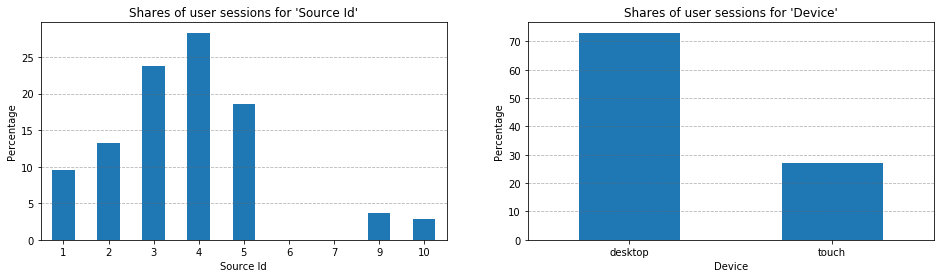

The number of user sessions for different values of 'Source Id':


Source Id,1,2,3,4,5,6,7,9,10
Uid,34121,47626,85610,101794,66905,6,36,13277,10025


The number of user sessions for different values of 'Device':


Device,desktop,touch
Uid,262567,96833


In [13]:
#Let's look at the number and share of user sessions for diffrent values in 'source_id' and 'device' columns
cat_columns = ['Source Id', 'Device']

#plotting share of user sessions
fig, axes = plt.subplots(ncols=2, figsize=(8*2, 4))
for i, col in enumerate(cat_columns):
    (visits.groupby(col).Uid.count()/len(visits)*100).plot(kind='bar', ax=axes[i]);
    axes[i].set_title("Shares of user sessions for '" + col + "'")
    axes[i].grid(axis='y', linestyle='--', color='dimgray', alpha=0.5)
    axes[i].xaxis.set_tick_params(rotation=0)
    axes[i].set_ylabel('Percentage')
plt.show()

#calculating the number of user sessions
for col in cat_columns:
    print(BOLD + "The number of user sessions for different values of '" + col + "':" + END) 
    display(visits.groupby(col).agg({'Uid':'count'}).T)

*The share of the sessions for the different sources are not uniform. The two most popular sources out of 9 have delivered half of all users. There are very few user sessions that came from sources that do not require direct costs: 6 and 36, respectively.*

*There are more than 2.5 times more sessions from a desktop than from devices with a touchpad.*

### 1.3 Data Preprocessing
<a id='section1.3'></a>

In [14]:
#Let's rename columns in oder to make it convenient to work with them
visits.rename(columns={'Device': 'device',
                       'Start Ts': 'start_datetime',
                       'End Ts': 'end_datetime',
                       'Source Id': 'source_id',
                       'Uid': 'user_id'}, inplace=True)

orders.rename(columns={'Buy Ts': 'buy_datetime',
                       'Revenue': 'revenue',
                       'Uid': 'user_id'}, inplace=True)

costs.rename(columns={'dt': 'date'}, inplace=True)

#converting excess type with help of astype() method:
visits['source_id'] = visits.source_id.astype('int8') 
costs['source_id'] = costs.source_id.astype('int8') 

#discarding seconds
visits['end_datetime'] = visits['end_datetime'].dt.floor('T')

#droping missing values
orders = orders[orders.revenue != 0]

*Feature __names have been converted to appropriate ones for more convenient work with them__. __Excess types__ for `'source_id'` columns __were converted to proper ones__. We discard seconds for a small number of dates where they were 19. Orders with zero `'revenue'` have been removed.*

### Conclusions
<a id='section1.4'></a>

The dataset contains information about 359,400 sessions of site visitors from June 1, 2017 to June 1, 2018. Visitors made 50,415 purchases and spend \\$2.5 per order on average. There are 9 ad sources, only 7 of them require direct marketing spend. On average, an ad source requires about \\$80 per day. Users also know the type of device from which they entered the site. Moreover, there are more than 2.5 times more sessions from a desktop than from devices with a touchpad.

To prepare the data for further analysis, the following steps were taken:
1. After checking the contents of the object type columns in the small dataset, we loaded the complete data with the appropriate types.
2. Excess types were converted to proper ones. 
3. Feature names have been converted to appropriate ones for more convenient work with them.
4. Orders with zero 'revenue' have been removed as missing values.
5. Abnormally high values of 'revenue' and 'costs' were examined, and 2 points were marked in order to take them into account in further analysis. It makes sense to contact the developer who sent the source file.
6. In all datetime columns except some values for 'End Ts' there are no seconds in time. We discarded all seconds for the convenience of further calculations.

## 2. Calculating Metrics
<a id='section2'></a>

### 2.1 Product metrics
<a id='section2.1'></a>

In [15]:
#some calculations for further evaluations
#creating dates coresponding to day, week (first day of week) and month(first day of month)
visits['session_date'] = pd.to_datetime(visits.start_datetime.dt.date)
visits['session_week'] = get_start_of_week(visits.session_date)
visits['session_month'] = visits.start_datetime.astype('datetime64[M]')

#Let's figure out when each user first came to the site
first_session_datetime = visits.groupby(['user_id']).start_datetime.min()
first_session_datetime.name = 'first_session_datetime' 
visits = visits.merge(first_session_datetime.reset_index(), on='user_id')

visits['first_session_date'] = pd.to_datetime(visits.first_session_datetime.dt.date)
visits['first_session_week'] = get_start_of_week(visits.first_session_date) 
visits['first_session_month'] = visits.first_session_date.astype('datetime64[M]') 

#Let's figure out how long ago each user first came to the site
visits['lifetime_days'] = (visits.session_date - visits.first_session_date) / np.timedelta64(1,'D')   
visits['lifetime_days'] = visits.lifetime_days.astype(int) 

visits['lifetime_weeks'] = (visits.session_date - visits.first_session_date) / np.timedelta64(1,'W')   
visits['lifetime_weeks'] = visits.lifetime_weeks.astype(int) 

visits['lifetime_months'] = (visits.session_month - visits.first_session_month)/np.timedelta64(1,'M')
visits['lifetime_months'] = visits.lifetime_months.round().astype(int)

#creating a table with user features, when the user first came to the site and from which traffic source
users = visits.sort_values(['user_id', 'start_datetime'])\
    .drop_duplicates(['user_id', 'first_session_date', 'first_session_month'])\
    [['user_id', 'first_session_date', 'first_session_month', 'source_id']]
users.rename(columns={'source_id':'first_source_id'}, inplace=True)

#adding the first traffic source to the visit table
visits = visits.merge(users[['user_id', 'first_source_id']], on='user_id')

#### 2.1.1 User Activity

The dynamics and distribution of new acquared users:


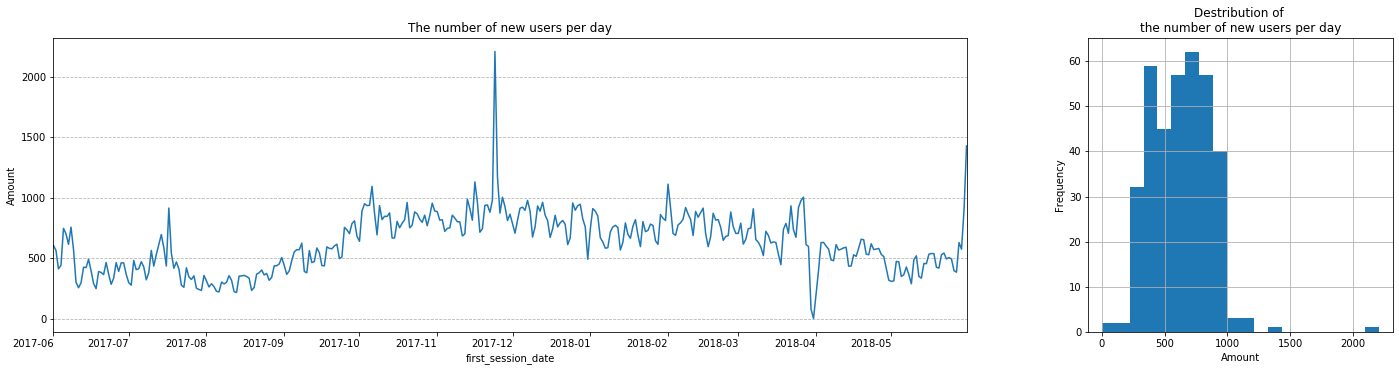

Descibtive statistics of the number of new users per day


,count,mean,std,min,25%,50%,75%,max
user_id,364.0,626.84,235.17,1.0,436.75,626.5,801.25,2207.0


In [16]:
#Let's look at how many new users are acquired each day 
print(BOLD + "The dynamics and distribution of new acquared users:" + END) 
fig, axes = plt.subplots(ncols=2, figsize=(24, 6), gridspec_kw={'width_ratios':[3,1]})
new_users_by_date = visits[visits.first_session_datetime==visits.start_datetime]\
    .groupby('first_session_date').user_id.nunique()
new_users_by_date.plot(ax=axes[0]);
axes[0].grid(axis='y', linestyle='--', color='dimgray', alpha=0.5)
axes[0].set_title('The number of new users per day')
axes[0].set_ylabel('Amount')
axes[0].xaxis.set_tick_params(rotation=0)

new_users_by_date.hist(ax=axes[1], bins=20);
axes[1].set_title('Destribution of \nthe number of new users per day')
axes[1].set_xlabel('Amount')
axes[1].set_ylabel('Frequency')
plt.show()

print(BOLD + 'Descibtive statistics of the number of new users per day' + END)
display(round(new_users_by_date.reset_index().describe().T, 2))

*__On average__, the site acquires  __600 new users per day.__*

*The __highest peak of new visiters__ occurs __at the end of November 2017__. Almost 2,000 new users were acquired. Perhaps it was some kind of advertising campaign. But it is worth finding out what was additionally undertaken that day. There is also __a smaller peak for the very last day__ of the dataset. There is also __a sharp drop__ in website traffic to 1 user __at the end of March 2018__. Either we have an incomplete data set, or there were some problems on the site, but then we would have to take care to turn off advertising campaigns on time. It is also worth finding out what happened on that date.*

The dynamics of active users metrics:


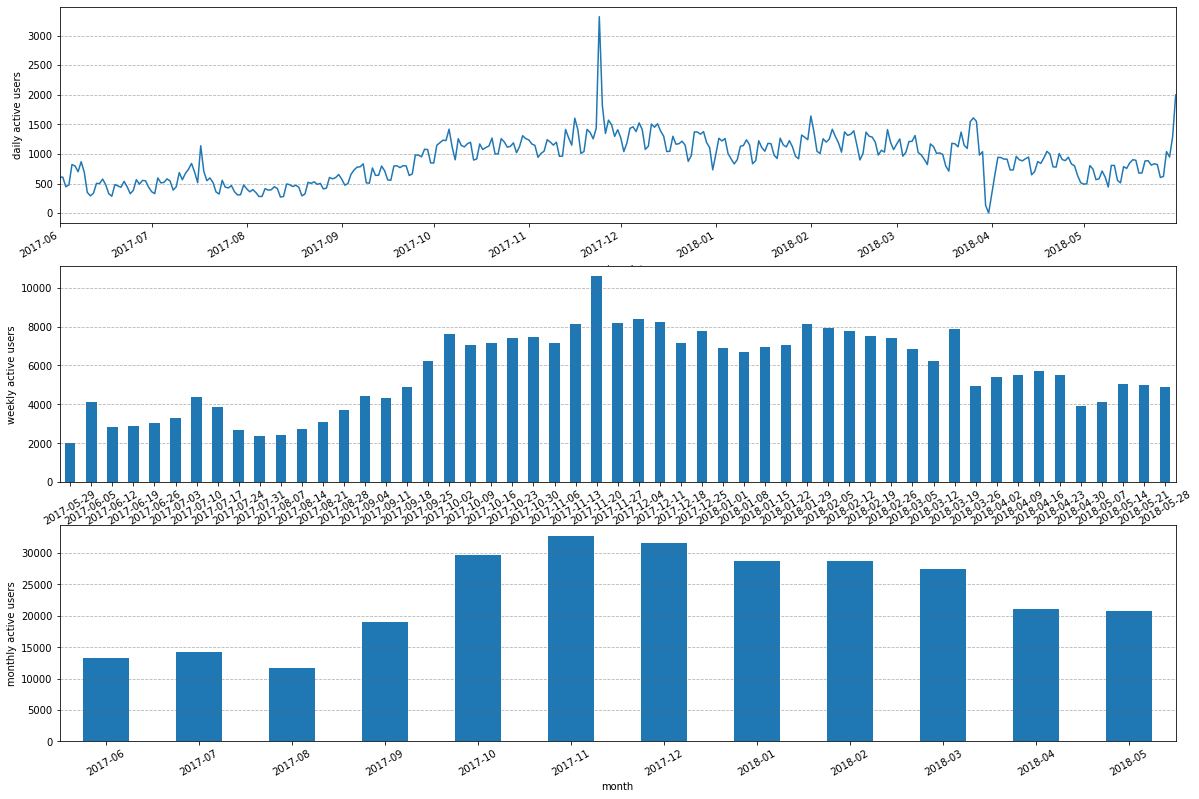

The distribution of active user metrics:


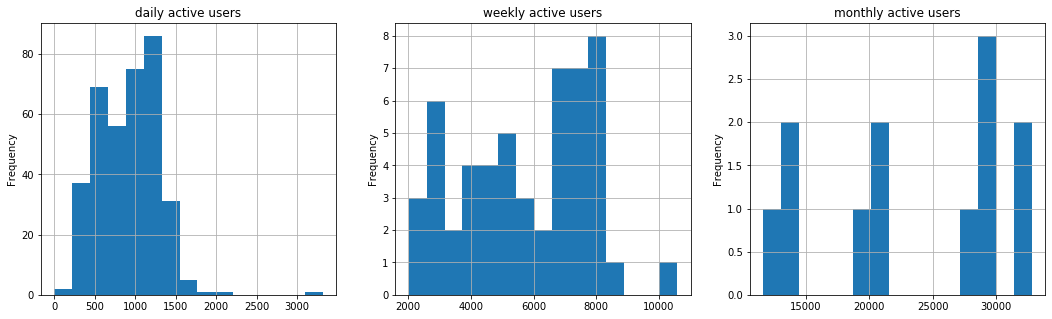

Describtive statistics for daily active users


,count,mean,std,min,25%,50%,75%,max
users_per_day,364.0,907.99,370.51,1.0,594.0,921.0,1173.0,3319.0


Describtive statistics for weekly active users


,count,mean,std,min,25%,50%,75%,max
user_id,53.0,5716.25,2049.9,2021.0,4128.0,5740.0,7401.0,10586.0


Describtive statistics for monthly active users


,count,mean,std,min,25%,50%,75%,max
user_id,12.0,23228.42,7546.38,11631.0,17777.0,24240.5,28984.75,32797.0


The point estimate of the number of active users:


,DAU,WAU,MAU
active users metrics,907,5716,23228


In [17]:
#Let's compare daily active users(DAU), weekly active users(WAU) and monthly active users(MAU) over time
#creating dates coresponding date, week (first day of week) and month(first day of month)
#calculating the number of active users for different periods of time
n_users_daily = visits.groupby('session_date').user_id.nunique()
n_users_daily.name = 'users_per_day'
n_users_weekly = visits.groupby(visits.session_week.dt.date).user_id.nunique()
n_users_monthly = visits.groupby(visits.session_month.dt.to_period('M')).user_id.nunique()

active_users_stats = [n_users_daily, n_users_weekly, n_users_monthly]
descriptions = ['daily active users', 'weekly active users', 'monthly active users']

#function to plot graphs one under the other
def plot_in_col(time_series, description):
    fig, axes = plt.subplots(nrows=3, figsize=(20, 5*3))
    for i, (series, descr) in enumerate(zip(time_series, description)): 
        if i == 0:
            series.plot(ax=axes[i])
        else:
            series.plot(kind='bar', ax=axes[i])
        axes[i].set_ylabel(descr) 
        axes[i].xaxis.set_tick_params(rotation=30)
        axes[i].grid(axis='y', linestyle='--', color='dimgray', alpha=0.5)
    axes[1].set_xlabel('calender week')
    axes[2].set_xlabel('month')
    plt.show()

#function to plot histograms in a row
def hist_in_row(time_series, description):
    cols_num = len(time_series)
    fig, axes = plt.subplots(ncols=cols_num, figsize=(6*cols_num, 5))
    for i, (series, descr) in enumerate(zip(time_series, description)):
        series.hist(ax=axes[i], bins=15);
        axes[i].set_title(descr)
        axes[i].set_ylabel('Frequency')
    plt.show()

print(BOLD + "The dynamics of active users metrics:" + END) 
plot_in_col(active_users_stats, descriptions)
print(BOLD + "The distribution of active user metrics:" + END) 
hist_in_row(active_users_stats, descriptions)

#printing describtive statistics for active user metrics
for stat, descr in zip(active_users_stats, descriptions):
    print('Describtive statistics for ' + BOLD + descr + END)
    display(round(pd.DataFrame(stat.describe()).T, 2))
    
#calculating the average point estimate of the number of active users:
active_users = pd.DataFrame({'DAU': int(n_users_daily.mean()),
                             'WAU': int(n_users_weekly.mean()),
                             'MAU': int(n_users_monthly.mean())},
                             index = ['active users metrics'])
print(BOLD + "The point estimate of the number of active users:" + END) 
display(round(active_users, 3))

*__On average__, the site has __900 unique users per day, 5,700 unique users per week, and 23,000 unique users per month__.*

*There are peaks and a drop at the same dates as for new users.*  

*__Seasonal changes__ in user activity can be distinguished. In summer the number of active users is less, in autumn the number of users grows and again decreases closer to summer. These 3 activity levels can be seen on the monthly activit users histogram.*

In [18]:
#Let's figure out the day with the maximum and minimum number of visitors on the site
print(BOLD + 'The day with the maximum number of visitors on the site:' + END) 
display(n_users_daily[n_users_daily==n_users_daily.max()])
print(BOLD + 'The day with the minimum number of visitors on the site:' + END) 
display(n_users_daily[n_users_daily==n_users_daily.min()])

The day with the maximum number of visitors on the site:


session_date
2017-11-24    3319
Name: users_per_day, dtype: int64

The day with the minimum number of visitors on the site:


session_date
2018-03-31    1
Name: users_per_day, dtype: int64

*It is worth checking the dates November 24, 2017 and March 31, 2018. November 24, 2017 was a Friday, it could be a black Friday*

The point estimate of sticky factors of active users:


,sticky_wau,sticky_mau
sticky metrics,0.159,0.039


The dynamics of sticky facrors:


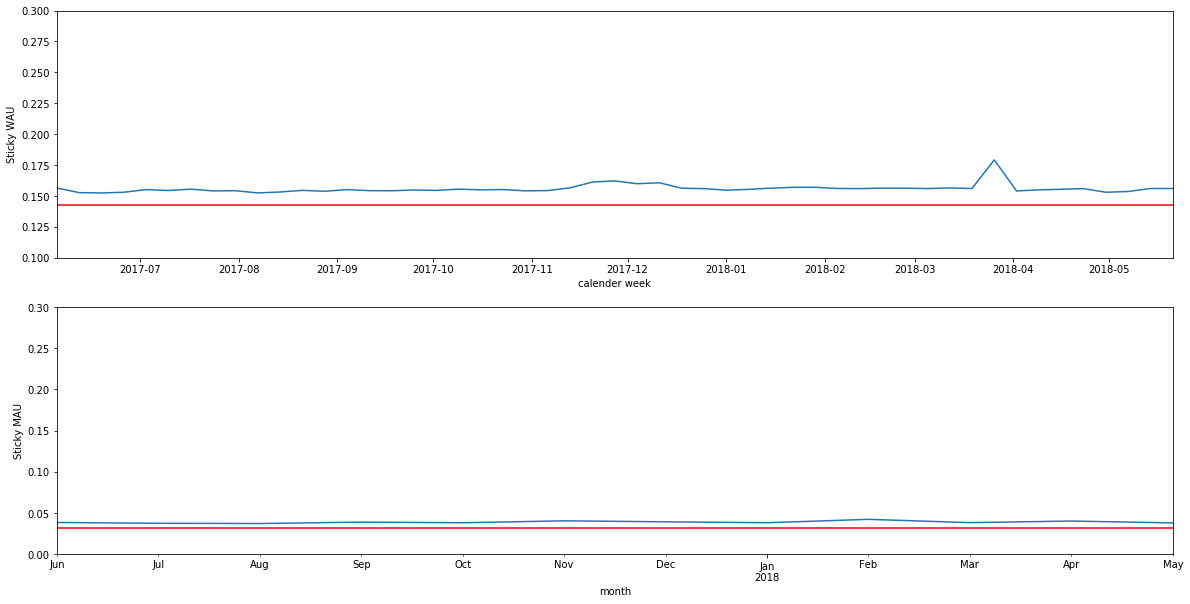

In [19]:
#Let's calculate sticky factors
#calculating the point estimate of sticky factors of active users:
sticky_metrics = pd.DataFrame({'sticky_wau': (active_users.DAU/active_users.WAU).values ,
                               'sticky_mau': (active_users.DAU/active_users.MAU).values},
                               index = ['sticky metrics'])
print(BOLD + "The point estimate of sticky factors of active users:" + END) 
display(round(sticky_metrics, 3))

#Let's calculate the dynamics of sticky factors of active users
#creating separate columns for day, week and month. 
n_users_daily = n_users_daily.reset_index()
n_users_daily['session_week'] = get_start_of_week(n_users_daily.session_date).dt.date
n_users_daily['session_month'] = n_users_daily.session_date.dt.to_period('M')

print(BOLD + "The dynamics of sticky facrors:" + END) 
fig, axes = plt.subplots(nrows=2, figsize=(20, 5*2))
#plotting sticky WAU (excluding incomplete first and last weeks)
(n_users_daily.groupby('session_week').users_per_day.mean()/n_users_weekly)[1:][:-1].plot(ax=axes[0]);
axes[0].set_ylabel('Sticky WAU');                      
axes[0].set_xlabel('calender week');
axes[0].axhline(y=1/7, color='r', linestyle='-');
axes[0].set_ylim(0.1, 0.3);

#plotting sticky MAU
(n_users_daily.groupby('session_month').users_per_day.mean()/n_users_monthly).plot(ax=axes[1]);
axes[1].set_ylabel('Sticky MAU');                   
axes[1].set_xlabel('month');
axes[1].axhline(y=1/31, color='r', linestyle='-');
axes[1].set_ylim(0, 0.3);

*Sticky factors are quite low and do not change a lot over time. The values are close to those ones when completely different users visit the site every day. So users who visit the service on different days of the week or month have little overlap. But this is not surprising, because the concept of the site does not imply that the user visits the site and buys tickets every day.*

Distribution of the number of daily active users by traffic source and device:


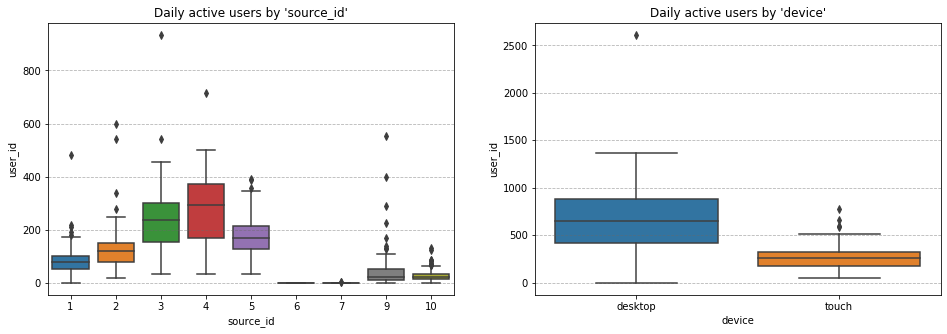

Describtive statistics of the number of daily active users by traffic source and device:


,count,mean,std,min,25%,50%,75%,max
source_id,,,,,,,,
1,364.0,80.56,41.81,1.0,51.0,79.0,102.0,483.0
2,363.0,120.71,59.07,17.0,79.5,119.0,150.5,599.0
3,363.0,232.87,96.66,32.0,153.0,236.0,302.0,932.0
4,363.0,275.45,120.79,32.0,167.5,294.0,371.0,716.0
5,363.0,175.62,64.87,32.0,127.5,169.0,214.5,392.0
6,6.0,1.00,0.00,1.0,1.0,1.0,1.0,1.0
7,34.0,1.06,0.24,1.0,1.0,1.0,1.0,2.0
9,363.0,36.11,46.91,1.0,9.5,22.0,51.5,555.0
10,363.0,26.03,17.87,1.0,14.0,22.0,34.5,132.0


,count,mean,std,min,25%,50%,75%,max
device,,,,,,,,
desktop,364.0,659.24,284.77,1.0,421.75,649.0,877.0,2605.0
touch,363.0,252.87,102.04,46.0,173.50,264.0,322.0,777.0


In [20]:
#Let's look at the number of daily active users by traffic source and devices.
cat_columns = ['source_id', 'device']

print(BOLD + 'Distribution of the number of daily active users by traffic source and device:' + END)
fig, axes = plt.subplots(ncols=2, figsize=(8*2, 5))
for i, col in enumerate(cat_columns):

    sns.boxplot(x=col, y='user_id', ax=axes[i],
                data=visits.groupby(['session_date', col]).user_id.nunique().reset_index());
    axes[i].set_title("Daily active users by '" + col + "'")
    axes[i].grid(axis='y', linestyle='--', color='dimgray', alpha=0.5)
plt.show()

print(BOLD + 'Describtive statistics of the number of daily active users by traffic source and device:' + END)
cat_columns = ['source_id', 'device']
for i, col in enumerate(cat_columns):
    display(round(visits.groupby(['session_date', col]).user_id.nunique().reset_index()\
                         .groupby(col).user_id.describe(),2))

*Different traffic sources come with a different number of users every day. Sources 9 and 10 deliver only a couple of dozen users per day, while sources 3, 4, on average, deliver a couple of hundred users per day. There were only a few days when users came from sources that did not require direct marketing expenses (see describtive statistics for sources 6 and 7).*

*On average, 2.5 times more active users use a desktop than devices with a touchpad.*

#### 2.1.2 User Sessions

The dynamics of the number of sessions and the number of unique users:


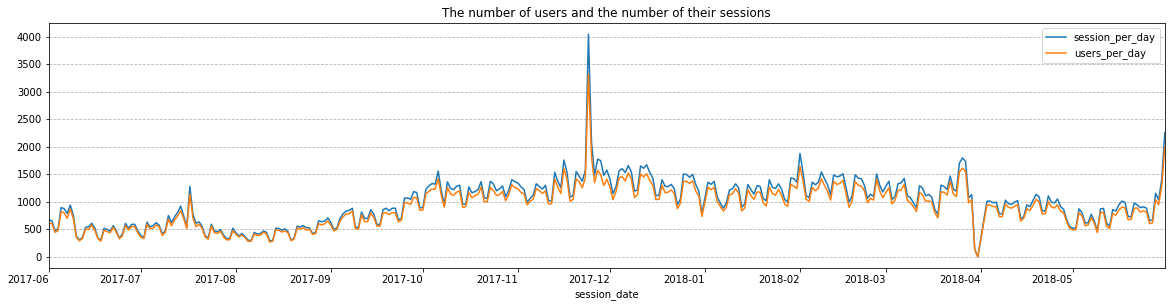

The dynamics of the number of sessions per day per user:


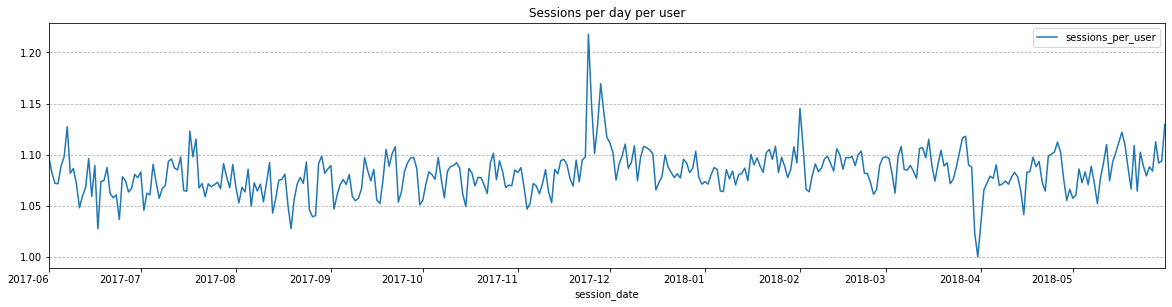

The distribution of the number of sessions per day per user:


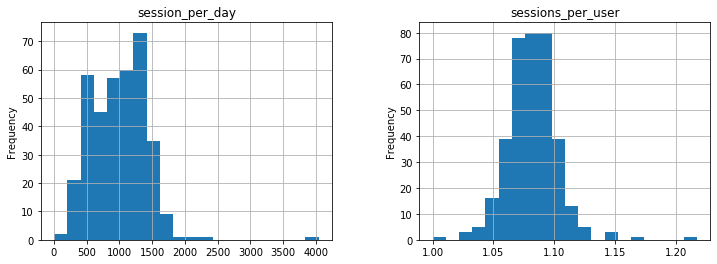

Describtive statistics for the number of sessions per day:


,count,mean,std,min,25%,50%,75%,max
session_per_day,364.0,987.36,418.99,1.0,635.5,1003.0,1280.0,4042.0


Describtive statistics for the number of sessions per day per user:


,count,mean,std,min,25%,50%,75%,max
sessions_per_user,364.0,1.08,0.02,1.0,1.07,1.08,1.09,1.22



Distribution of the number of sessions per day per user by traffic source and device:
The dynamics of the number of sessions by device:


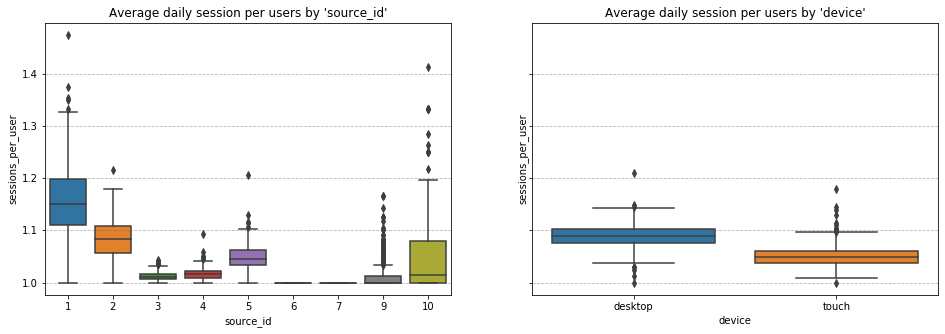

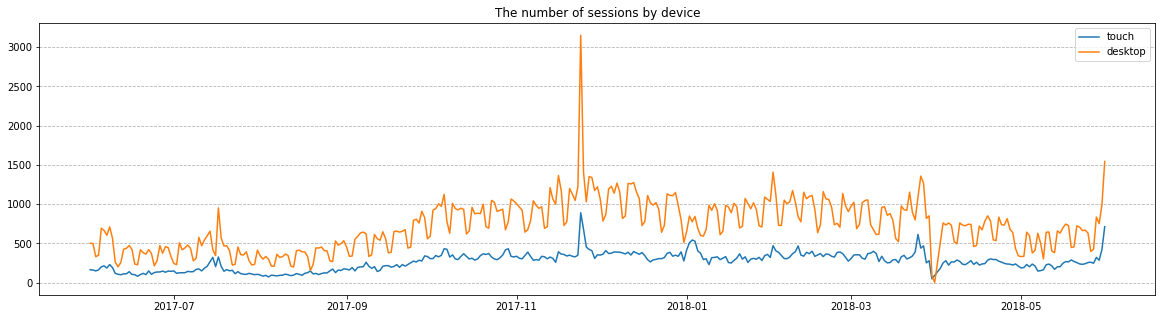

In [21]:
#Let's look at the number of sessions per day
#calculating the number of sessions per day and comparing them with the number of unique users per day
n_session_per_day = visits.groupby('session_date').agg({'user_id': ['count']})
n_session_per_day.columns = ['session_per_day']

n_users_per_day = visits.groupby('session_date').agg({'user_id': ['nunique']})
n_users_per_day.columns = ['users_per_day']

print(BOLD + 'The dynamics of the number of sessions and the number of unique users:' + END) 
#ploting the daily number of sessions and unique users
fig, ax = plt.subplots(figsize=(20, 5))
n_session_per_day.plot(ax=ax);
n_users_per_day.plot(ax=ax);
ax.set_title('The number of users and the number of their sessions');
ax.grid(axis='y', linestyle='--', color='dimgray', alpha=0.5)
ax.xaxis.set_tick_params(rotation=0)
plt.show()

#calculating the number of sessions per user per day metric
sessions_per_user = pd.DataFrame(n_session_per_day.session_per_day/n_users_per_day.users_per_day,
                                 columns=['sessions_per_user'])

print(BOLD + 'The dynamics of the number of sessions per day per user:' + END) 
#ploting the daily number of sessions per day per user
ax = sessions_per_user.plot(figsize=(20, 5));
ax.set_title('Sessions per day per user');
ax.grid(axis='y', linestyle='--', color='dimgray', alpha=0.5)
ax.xaxis.set_tick_params(rotation=0)
plt.show()

print(BOLD + 'The distribution of the number of sessions per day per user:' + END) 
fig, axes = plt.subplots(ncols=2, figsize=(6*2, 4))
n_session_per_day.hist(ax=axes[0], bins=20);
sessions_per_user.hist(ax=axes[1], bins=20);
for i in range(2):
    axes[i].set_ylabel('Frequency')
plt.show()


print('Describtive statistics for ' + BOLD + 'the number of sessions per day:' + END)
display(round(n_session_per_day.describe().T, 2))
print('Describtive statistics for ' + BOLD + 'the number of sessions per day per user:' + END)
display(round(sessions_per_user.describe().T, 2))
print()

print(BOLD + 'Distribution of the number of sessions per day per user by traffic source and device:' + END)
fig, axes = plt.subplots(ncols=2, figsize=(8*2, 5), sharey=True)
for i, col in enumerate(cat_columns):

    n_session_per_day_by_col = visits.groupby(['session_date', col]).agg({'user_id': ['count']})
    n_session_per_day_by_col.columns = ['session_num']
    n_users_per_day_by_col = visits.groupby(['session_date', col]).agg({'user_id': ['nunique']})
    n_users_per_day_by_col.columns = ['users_num']

    sessions_per_user_by_col = pd.DataFrame(n_session_per_day_by_col.session_num/n_users_per_day_by_col.users_num,
                                               columns=['sessions_per_user']).reset_index()

    sns.boxplot(x=col, y='sessions_per_user', data=sessions_per_user_by_col, ax=axes[i]);
    axes[i].set_title("Average daily session per users by '" + col + "'")
    axes[i].grid(axis='y', linestyle='--', color='dimgray', alpha=0.5)

#ploting the daily number of sessions by device
print(BOLD + 'The dynamics of the number of sessions by device:' + END) 
fig, ax = plt.subplots(figsize=(20, 5))
for device in visits.device.unique():
    data = visits.groupby(['session_date', 'device']).user_id.count().reset_index()\
        .query('device==@device')
    ax.plot(data.session_date, data.user_id, label=str(device));
ax.set_title('The number of sessions by device');
ax.legend()
ax.grid(axis='y', linestyle='--', color='dimgray', alpha=0.5)
ax.xaxis.set_tick_params(rotation=0)
plt.show()

*The number of sessions per day is slightly higher than the number of active users. __On average, each user spends at most 1 session on the service per day__.*

*At the end of November, when there were the most users on the site, a larger number of users returned to the site during the day. Perhaps to take advantage of the terms of the promotion or there were some problems on the site due to the large number of people on the site at the same time. Another peak repeated a few days after that. Perhaps some users wanted to know if the promotion is still valid or to clarify additional information.*

*For some traffic sources, it is typical that some users revisit the site during the day. This might be the case for search traffic or retargeting campaigns.*

*Some desktop users are more likely to revisit the site than touchpad device users, likely due to the different nature of content consumption on different devices. The number of sessions on desktops is greater than on touch devices. In general, the trend is repeated on both devices.*

The dynamics of the lenght of a session:


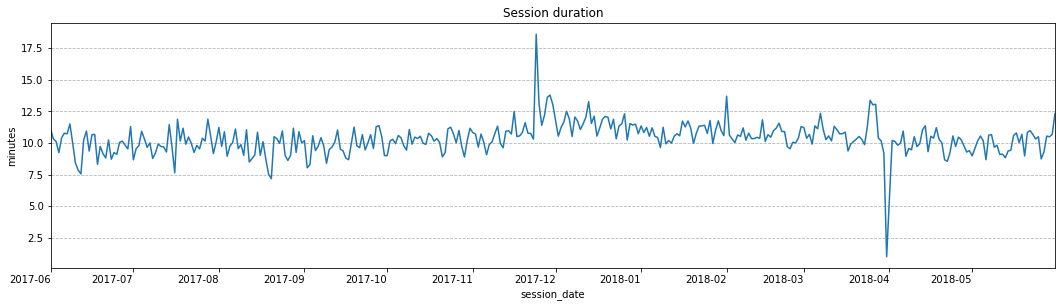

The share of sessions less than half an hour:


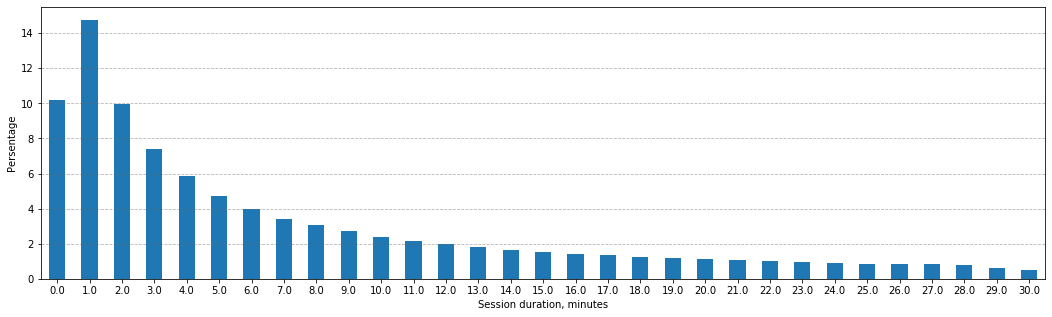

Describtive statistics for the length of a session:


,count,mean,std,min,25%,50%,75%,max
"session_duration, minutes",359400.0,10.72,16.94,0.0,2.0,5.0,14.0,1408.0


In [22]:
#Let's look at the length of each session
#calculating the session duration
session_duration = (visits.end_datetime - visits.start_datetime).dt.seconds/60

print(BOLD + 'The dynamics of the lenght of a session:' + END) 
ax = (session_duration.groupby(visits.session_date).mean()).plot(figsize=(18, 5));
ax.set_title('Session duration');
ax.set_ylabel('minutes')
ax.grid(axis='y', linestyle='--', color='dimgray', alpha=0.5)
ax.xaxis.set_tick_params(rotation=0)
plt.show()

print(BOLD + 'The share of sessions less than half an hour:' + END) 
ax = (session_duration[session_duration<31].value_counts(sort=False).sort_index()/len(visits)*100)\
    .plot(kind='bar', figsize=(18, 5));
ax.set_xlabel('Session duration, minutes')
ax.set_ylabel('Persentage')
ax.grid(axis='y', linestyle='--', color='dimgray', alpha=0.5)
ax.xaxis.set_tick_params(rotation=0)
plt.show()

print('Describtive statistics for ' + BOLD + 'the length of a session:' + END)
display(round(pd.DataFrame((session_duration).describe(), columns=['session_duration, minutes']).T, 2))

In [23]:
session_duration.name = 'session_duration'
session_duration.groupby(visits.session_date).mean().reset_index()\
    .query('session_duration==session_duration.max()')

,session_date,session_duration
176,2017-11-24,18.606136


*Note that the start and end times of sessions have been rounded up to minutes, so the duration of a session is measured in minutes.*

*The mean for the session length is about 10 minutes. At the end of November, when there were the most users on the site, the average session length was slightly longer. When at the end of March there was only one user on the site for the whole day, the length of his session was about a minute.*

*The average is biased due to the presence of very long sessions (the maximum session length was almost a day). The median for the session length is 5 minutes. If you look at __the most popular session lengths, more than 14% of sessions last only a minute and 10% of sessions last less than a minute. Most users don't stay on the site for long.__ Either the service did not interest them at all, or the service is set up so well that you can quickly buy a ticket of interest.*

#### 2.1.3 Retention

The number of users of the website is 228,169
The number of users visited the site for the second time is 45,045, which is 19.7%

The share of loyal users distributed according to the dates when they come back the next time:


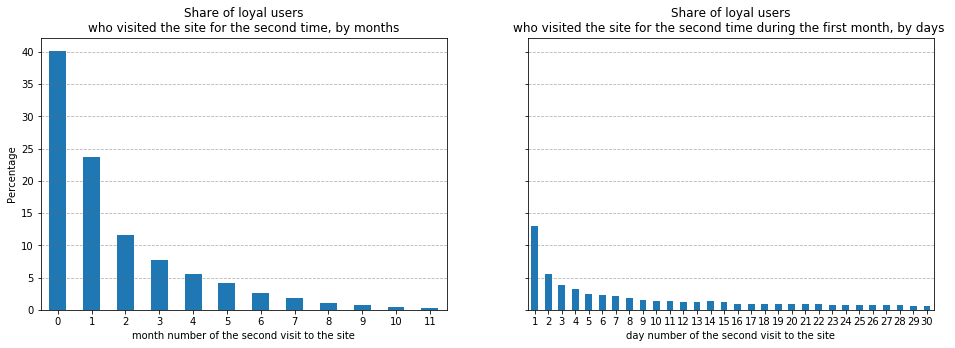

The share of loyal users by source:


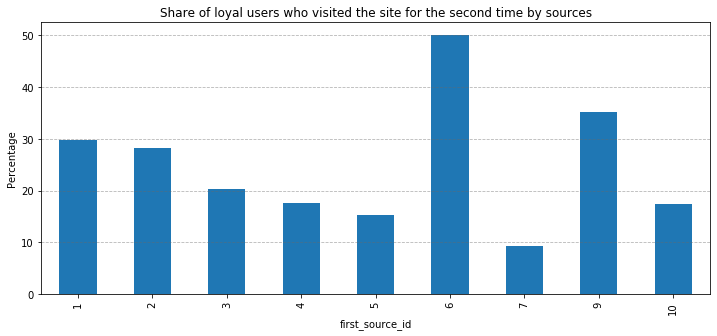

In [24]:
#Let's look at how many users come back to the site the next days
unique_users = visits.user_id.nunique()
loyal_users = visits[visits.lifetime_days>0].user_id.nunique()
print('The number of users of the website is ' + BOLD + '{:,}'.format(unique_users) + END)
print('The number of users visited the site for the second time is ' + BOLD + '{:,}'.format(loyal_users) + END 
      + ', which is ' + BOLD + '{:.1%}'.format(loyal_users/unique_users) + END)
print()

#Let's look at how the users who come back to the site are distributed according to the dates
#when they come back the next time.
print(BOLD + 'The share of loyal users distributed according to the dates when they come back the next time:' + END) 
fig, axes = plt.subplots(ncols=2, figsize=(8*2, 5), sharey=True)
(visits[visits.lifetime_days>0].groupby('user_id').lifetime_months.min().value_counts(sort=False)\
     /visits[visits.lifetime_days>0].user_id.nunique() * 100).plot(kind='bar', ax=axes[0]);
axes[0].set_title('Share of loyal users\nwho visited the site for the second time, by months');
axes[0].set_xlabel('month number of the second visit to the site');

(visits[(visits.lifetime_days>0)&(visits.lifetime_days <= 30)].groupby('user_id').lifetime_days.min()\
    .value_counts(sort=False).sort_index()\
        /visits[visits.lifetime_days>0].user_id.nunique() * 100).plot(kind='bar', ax=axes[1]);
axes[1].set_title('Share of loyal users\nwho visited the site for the second time during the first month, by days ');
axes[1].set_xlabel('day number of the second visit to the site');
for i in range(2):
    axes[i].grid(axis='y', linestyle='--', color='dimgray', alpha=0.5)
    axes[i].xaxis.set_tick_params(rotation=0)
    axes[i].set_ylabel('Percentage')
plt.show()
    
#Let's look at the share of the users who come back to the site by the first source they came from
print(BOLD + 'The share of loyal users by source:' + END)
ax = (visits[visits.lifetime_days>0].groupby('first_source_id').user_id.nunique()\
          /visits.groupby('first_source_id').user_id.nunique()*100).plot(kind='bar', figsize=(12, 5));
ax.set_title('Share of loyal users who visited the site for the second time by sources');
ax.set_ylabel('Percentage');
ax.grid(axis='y', linestyle='--', color='dimgray', alpha=0.5)

*__80% of users visited the site only once and have never come back__. Of the 20% of the remaining users, 40% of the users came to the site back within the next month. The remaining 60% of loyal users came back for the second time after a fairly long period of time during the year. Only slightly more than 10% of loyal users came back the next day.*

*The nature of the service, in general, does not imply for the user to visit the site every day. Thus, Retention Nd metric on day N would not be a suitable metric for comparing different cohorts and ad campaigns for them. It makes sense to compare Return Retention Nd and consider users who have been at least once within N days.*

*For source 6, 3 out of 6 users visited the site again. About 30% of users who came from traffic sources 1, 2 and 9 returned again to the site the next days during a given period of time. For other sources, the share of returning users is significantly lower.*

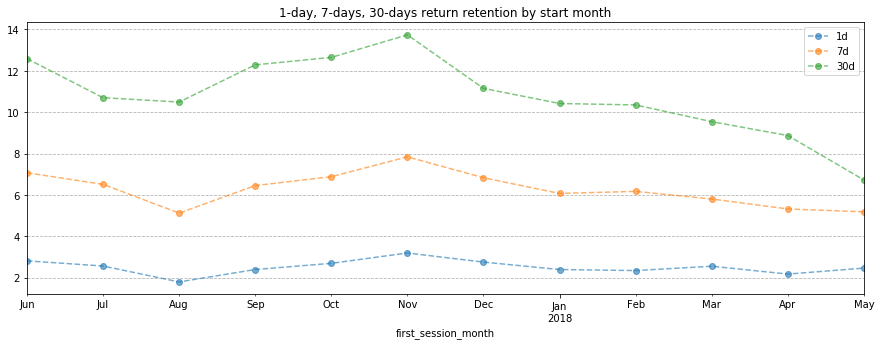

In [25]:
#Consider users acquired in different months 
#function to calculate return retention Nd by monthly cohorts
def get_return_retention(days):
    return visits.query('lifetime_days>=1 and lifetime_days<=@days')\
                   .groupby('first_session_month').user_id.nunique()\
               /visits.query('lifetime_days==0').groupby('first_session_month').user_id.nunique()

ax = round(pd.DataFrame({'1d': get_return_retention(1),
                         '7d': get_return_retention(7),
                        '30d': get_return_retention(30)})*100, 2)\
    .plot(figsize=(15, 5), style='o--', alpha=0.6);
ax.grid(axis='y', linestyle='--', color='dimgray', alpha=0.5)
ax.set_title('1-day, 7-days, 30-days return retention by start month');

*2-3% of users acquired in different months visit the site the next day. 5-8% of users come back within a week. The behavior of users from different cohorts during the first 30 days is slightly different. Retention is highest for the users acquired in November. Many of these users most likely revisited to the site on November 24th, when there might have been some kind of promotion. Retention values for the June, September and October cohorts are a little bit behind, but they also stands out from the rest. Retention within 30 days for cohorts aquired in 2018 is slightly lower.*

User retention for each monthly cohort per week for 2 months and per month:


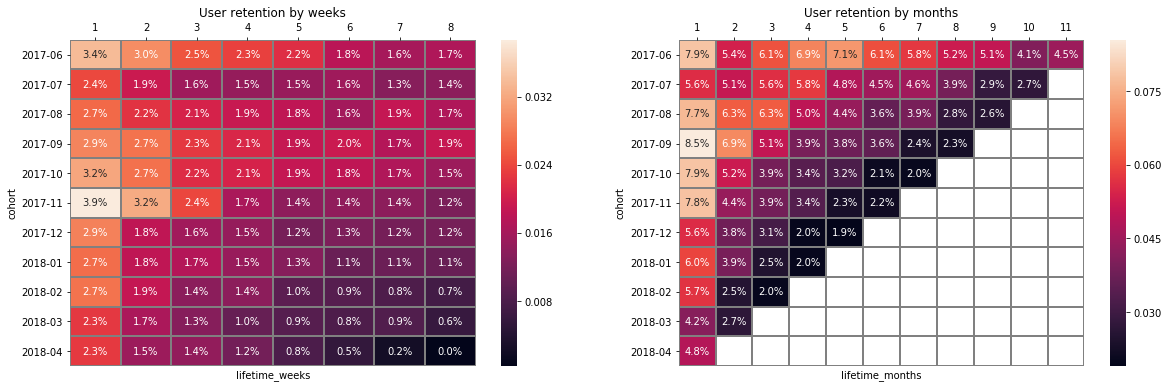

In [26]:
#Let's consider retention for cohorts by weeks for 2 months and by months for a year.
#function to calculate retention for different lifetime frequencies
def cohort_retention(lifetime_freq):
    cohorts = visits.groupby(['first_session_month', lifetime_freq])\
        .agg({'user_id': 'nunique'}).reset_index()
    initial_users_count = cohorts[cohorts[lifetime_freq] == 0]\
        [['first_session_month', 'user_id']] 
    initial_users_count = initial_users_count.rename(columns={'user_id':'cohort_users'}) 
    cohorts = cohorts.merge(initial_users_count, on='first_session_month')  
    cohorts['retention'] = cohorts['user_id'] / cohorts['cohort_users']  
    cohorts['cohort'] = cohorts.first_session_month.dt.to_period('M')

    return cohorts.pivot_table(index='cohort', columns=lifetime_freq,
                                          values='retention', aggfunc='sum') 

#ploting heatmap for retention table by weeks for monthly cohorts
print(BOLD + 'User retention for each monthly cohort per week for 2 months and per month:' + END)
fig, axes = plt.subplots(ncols=2, figsize=(10*2, 6))
ax = sns.heatmap(cohort_retention('lifetime_weeks').iloc[:-1,1:9], annot=True, fmt='.1%', linewidths=1,
                 linecolor='gray', ax=axes[0]); 
axes[0].set_title('User retention by weeks')
ax = sns.heatmap(cohort_retention('lifetime_months').iloc[:-1,1:], annot=True, fmt='.1%', linewidths=1,
                 linecolor='gray', ax=axes[1]); 
axes[1].set_title('User retention by months')
for i in range(2):
    axes[i].xaxis.tick_top()

*If we consider the retention of cohorts by weeks for 2 months and by months for a year, then the first cohort is also distinguished throughout the year, and the September and November cohorts are also distinguished. The retention of cohorts acquired in 2018 is slightly worse (note there is not enough data for the April cohort).*

User retention for each frafic source per month:


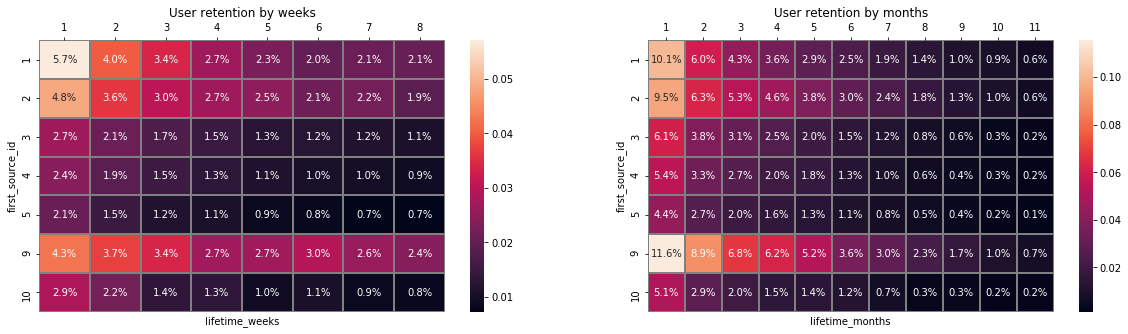

In [27]:
#Let's consider retention for different souces by weeks for 2 months and by months for a year.
#function to calculate retention for different lifetime frequencies by sources
def retention_by_source(lifetime_freq):
    users_by_source = visits.groupby(['first_source_id', lifetime_freq]).agg({'user_id': 'nunique'}).reset_index()
    initial_users_count = users_by_source[users_by_source[lifetime_freq] == 0][['first_source_id', 'user_id']] 
    initial_users_count = initial_users_count.rename(columns={'user_id':'initial_users'}) 
    users_by_source = users_by_source.merge(initial_users_count, on='first_source_id')  
    users_by_source['retention'] = users_by_source['user_id'] / users_by_source['initial_users']  

    return users_by_source.pivot_table(index='first_source_id', columns=lifetime_freq,
                                          values='retention', aggfunc='sum') 

print(BOLD + 'User retention for each frafic source per month:' + END)
#ploting heatmap for retention table by weeks and months for different sources
#remove sources 6, 7 since there is not enough data for them
fig, axes = plt.subplots(ncols=2, figsize=(10*2, 5))
ax = sns.heatmap(retention_by_source('lifetime_weeks').query('first_source_id not in (6, 7)').iloc[:,1:9],
                 annot=True, fmt='.1%', linewidths=1, linecolor='gray', ax=axes[0]); 
axes[0].set_title('User retention by weeks')
ax = sns.heatmap(retention_by_source('lifetime_months').query('first_source_id not in (6, 7)').iloc[:,1:],
                 annot=True, fmt='.1%', linewidths=1, linecolor='gray', ax=axes[1]); 
axes[1].set_title('User retention by months')
for i in range(2):
    axes[i].xaxis.tick_top()

*If we consider the retention for different sources by weeks for 2 months and by months for a year, then sources 1,2 and 9 are also distinguished.* 

### 2.2. Sales metrics
<a id='section2.2'></a>

#### 2.2.1 Conversion

The distribution of the conversion day:


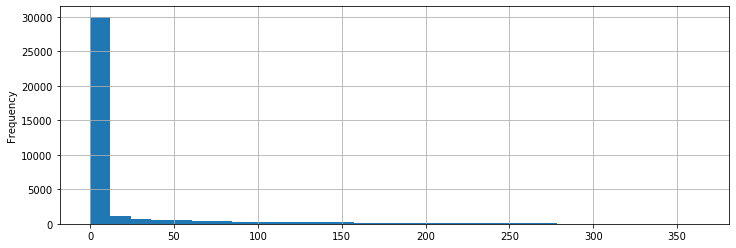

Describtive statistics for the conversion day:


,count,mean,std,min,25%,50%,75%,max
conversion,36508.0,16.91,47.09,0.0,0.0,0.0,2.0,363.0


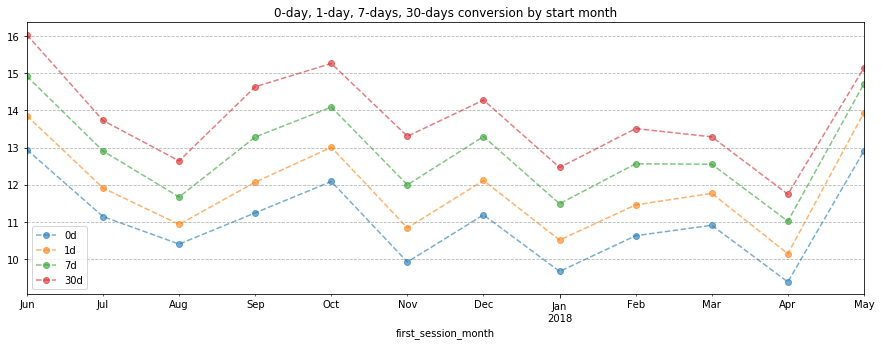

In [28]:
#Let's figure out when a user makes their first purchase
first_order_date = orders.groupby(['user_id']).agg({'buy_datetime':'min'})
conversions = first_order_date.merge(users, on='user_id')
conversions.rename(columns={'buy_datetime':'first_order_datetime'}, inplace=True) 

conversions['first_order_date'] = pd.to_datetime(conversions.first_order_datetime.dt.date)
conversions['first_order_month'] = conversions.first_order_date.astype('datetime64[M]') 

#calculating conversion day
conversions['conversion'] = (pd.to_datetime(conversions.first_order_datetime.dt.date) \
    - conversions.first_session_date)/np.timedelta64(1,'D')
conversions['conversion'] = conversions.conversion.astype(int)

print(BOLD + 'The distribution of the conversion day:' + END) 
ax = conversions.conversion.hist(figsize=(12, 4), bins=30);
ax.set_ylabel('Frequency')
plt.show()

print('Describtive statistics for ' + BOLD + 'the conversion day:' + END)
display(round(pd.DataFrame(conversions.conversion.describe()).T, 2))


#Consider users conversion in different months 
#function to calculate conversion Nd by monthly cohorts
def get_conversion(days):
    return conversions.query('conversion<=@days').groupby('first_session_month').user_id.nunique()\
             /visits.query('start_datetime==first_session_datetime').groupby('first_session_month').user_id.nunique()

ax=(pd.DataFrame({'0d': get_conversion(0),
                  '1d': get_conversion(1),
                  '7d': get_conversion(7),
                 '30d': get_conversion(30)})*100).plot(figsize=(15, 5), style='o--', alpha=0.6);
ax.grid(axis='y', linestyle='--', color='dimgray', alpha=0.5)
ax.set_title('0-day, 1-day, 7-days, 30-days conversion by start month');


*__The majority of users make a purchase on their first visit to the site__. Thus, users visit the site to buy a ticket. Although some users visit the site to buy a ticket a lot after the first visit to the site. Conversions of 0d, 1d, 7e, and 30e differ insignificantly. There are differences for different cohorts though. The first, last and October cohorts can be distinguished.*

Distribution of the conversion by traffic source:


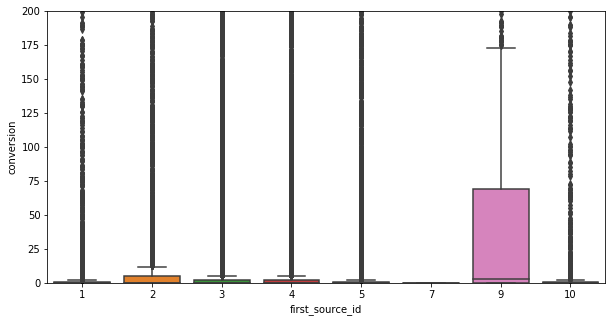

Describtive statistics of the conversion by traffic source:


,count,mean,std,min,25%,50%,75%,max
first_source_id,,,,,,,,
1,2896.0,10.360497,36.947704,0.0,0.0,0.0,1.00,363.0
2,3503.0,20.709963,52.030971,0.0,0.0,0.0,5.00,355.0
3,10467.0,17.609630,47.717279,0.0,0.0,0.0,2.00,358.0
4,10295.0,16.468674,46.181998,0.0,0.0,0.0,2.00,363.0
5,6931.0,13.924398,43.101836,0.0,0.0,0.0,1.00,356.0
7,1.0,0.000000,NaN,0.0,0.0,0.0,0.00,0.0
9,1088.0,44.640625,71.661119,0.0,0.0,3.0,69.25,356.0
10,1327.0,11.964582,40.542004,0.0,0.0,0.0,1.00,357.0


In [29]:
#Let's consider the conversion for different souces
print(BOLD + 'Distribution of the conversion by traffic source:' + END)
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(x='first_source_id', y='conversion', data=conversions, ax=ax);
ax.set_ylim(0, 200);
plt.show()

print(BOLD + 'Describtive statistics of the conversion by traffic source:' + END)
display(conversions.groupby('first_source_id').conversion.describe())

*__For most ad sources, the conversion occurs on the first day, as soon as the user visits the site__, or in the first few days. For source 9, for some users, the conversion is quite late. Perhaps these purchases occur after mailing or using other ways to maintain user loyalty using CRM.*

#### 2.2.2 The number of purchases

The dynamics of the number of purchases per day:


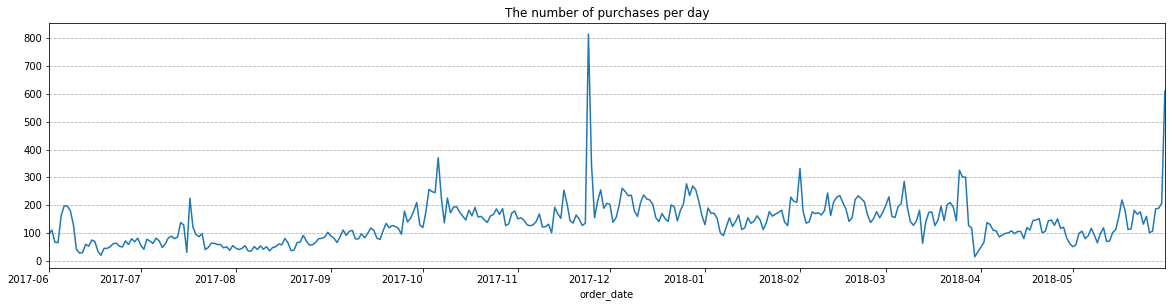

Describtive statistics for the number of purchases per day:


,count,mean,std,min,25%,50%,75%,max
user_id,363.0,138.74,76.57,15.0,83.0,136.0,177.0,814.0


The number of purchases per month for monthly cohorts:


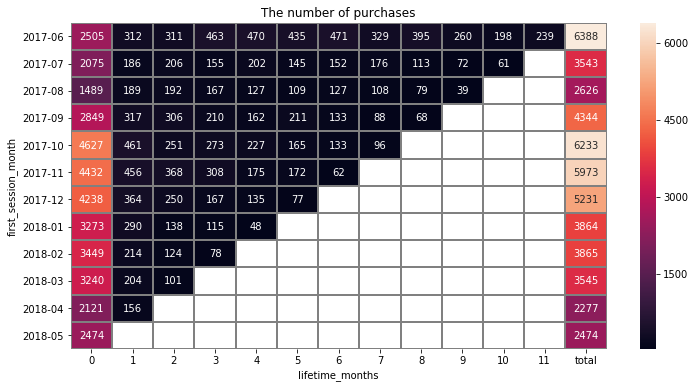

In [30]:
#Let's look at how many orders users make during different periods of time
#creating dates coresponding date and month(first day of month)
orders['order_date'] = pd.to_datetime(orders.buy_datetime.dt.date)
orders['order_month'] = orders.order_date.astype('datetime64[M]') 

orders = orders.merge(conversions, on='user_id')

#Let's figure out when users make their purchases in term of months
orders['lifetime_months'] = (orders.buy_datetime - orders.first_session_date)/np.timedelta64(1,'M')
orders['lifetime_months'] = orders.lifetime_months.astype(int).round().astype(int)

print(BOLD + 'The dynamics of the number of purchases per day:' + END) 
ax = orders.groupby('order_date').user_id.count().plot(figsize=(20, 5));
ax.set_title('The number of purchases per day');
ax.grid(axis='y', linestyle='--', color='dimgray', alpha=0.5)
ax.xaxis.set_tick_params(rotation=0)
plt.show()

print('Describtive statistics for ' + BOLD + 'the number of purchases per day:' + END)
display(round(pd.DataFrame(orders.groupby('order_date').user_id.count()\
                               .describe()).T, 2))

#Let's look at the number of purchases by months for monthly cohorts 
purchase_counts = orders.pivot_table(index='first_session_month', columns='lifetime_months',
                                 values='user_id', aggfunc='count')
purchase_counts['total'] = purchase_counts.sum(axis=1)

print(BOLD + 'The number of purchases per month for monthly cohorts:' + END)
plt.figure(figsize=(12, 6)) 
plt.title('The number of purchases') 
ax = sns.heatmap(purchase_counts, annot=True, fmt='g', linewidths=1, linecolor='gray'); 
dates = purchase_counts.reset_index()['first_session_month'].sort_values().dt.strftime('%Y-%m').unique()
ax.set_yticklabels(labels=dates);

*__On average, users make about 140 purchases per day__. But seasonal changes in user orders can be distinguished. In summer the number of purchases is less, in autumn the number of purchases increases, and after that, starting from April, the number of purchases becomes less.*

*The highest peak of perchases amount occurs at the end of November 2017 as well. The number of purchases has increased more than fivefold. There is also a smaller peak for the last day of the dataset. Also, at the end of March 2018, there is a sharp drop in the number of purchases on the site. The only user that day managed to buy tickets in 1 minute.*

*If we consider the purchase amount of cohorts by months over year, then the first cohort is distinguished throughout the year. This cohort saw increases after falls. We can distinguish the October, November, and December cohorts as well.*

The number of purchases per month for different traffic sources:


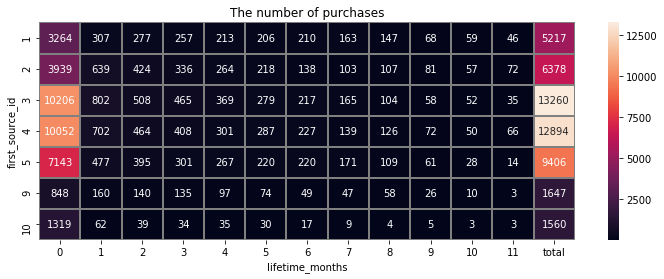

In [31]:
#Let's look at how many orders were placed by users who came from different traffic sources.
#ploting heatmap for the number of purcheses for different sources
#remove sources 6, 7 since there is not enough data for them
purchases_by_source = orders.pivot_table(index='first_source_id', columns='lifetime_months',
                                 values='user_id', aggfunc='count')
purchases_by_source['total'] = purchases_by_source.sum(axis=1)

print(BOLD + 'The number of purchases per month for different traffic sources:' + END)
plt.figure(figsize=(12, 4)) 
plt.title('The number of purchases') 
ax = sns.heatmap(purchases_by_source[~purchases_by_source.index.isin([6, 7])],
                 annot=True, fmt='g', linewidths=1, linecolor='gray'); 

*If we consider the number of purchses for different sources by months for a year, then sources 3, 4 and 5 are distinguished. For most months of life, the number of purchases for these sources is greater than for other ones.*

The number of purchases per month for monthly cohorts:


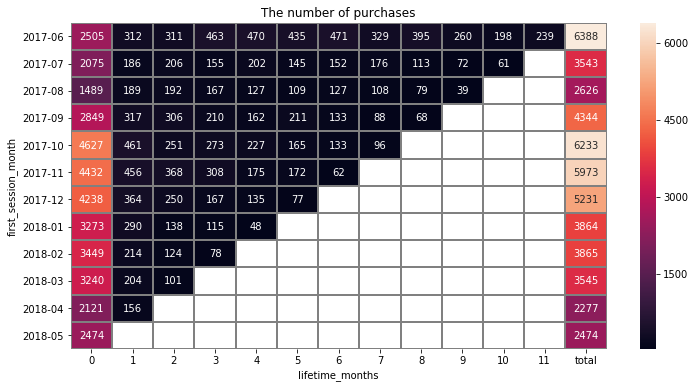

In [32]:
#Let's look at the number of purchases by months for monthly cohorts 
purchase_counts = orders.pivot_table(index='first_session_month', columns='lifetime_months',
                                 values='user_id', aggfunc='count')
purchase_counts['total'] = purchase_counts.sum(axis=1)

print(BOLD + 'The number of purchases per month for monthly cohorts:' + END)
plt.figure(figsize=(12, 6)) 
plt.title('The number of purchases') 
ax = sns.heatmap(purchase_counts, annot=True, fmt='g', linewidths=1, linecolor='gray'); 
dates = purchase_counts.reset_index()['first_session_month'].sort_values().dt.strftime('%Y-%m').unique()
ax.set_yticklabels(labels=dates);

In [33]:
orders.head()

,buy_datetime,revenue,user_id,order_date,order_month,first_order_datetime,first_session_date,first_session_month,first_source_id,first_order_date,first_order_month,conversion,lifetime_months
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-06-01 00:10:00,2017-06-01,2017-06-01,1,2017-06-01,2017-06-01,0,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-06-01 00:25:00,2017-06-01,2017-06-01,2,2017-06-01,2017-06-01,0,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2017-06-01 00:27:00,2017-06-01,2017-06-01,2,2017-06-01,2017-06-01,0,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2017-06-01 00:29:00,2017-06-01,2017-06-01,2,2017-06-01,2017-06-01,0,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,2017-06-01 07:58:00,2017-06-01,2017-06-01,3,2017-06-01,2017-06-01,0,0


#### 2.2.3 The average purchase size

The dynamics of the average purchase size per day:


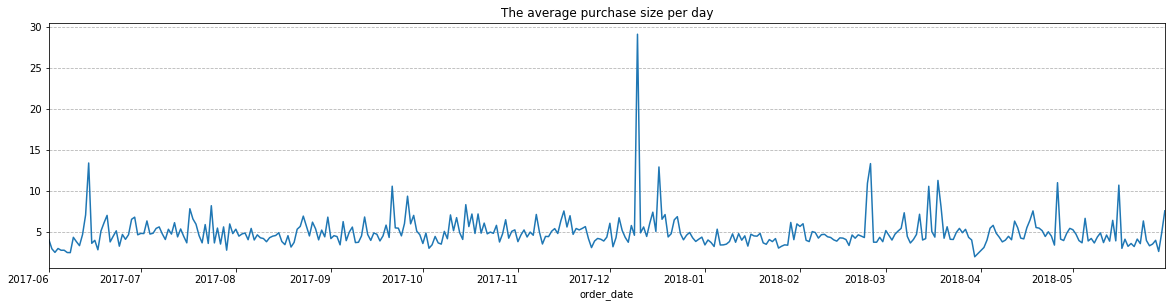

Describtive statistics for the average purchase size per day:


,count,mean,std,min,25%,50%,75%,max
revenue,363.0,4.95,2.02,1.95,3.97,4.57,5.41,29.13


In [35]:
#Let's look at the average purchase size per day
print(BOLD + 'The dynamics of the average purchase size per day:' + END) 
#ploting the daily average purchase size
ax = orders.groupby('order_date').revenue.mean().plot(figsize=(20, 5));
ax.set_title('The average purchase size per day');
ax.grid(axis='y', linestyle='--', color='dimgray', alpha=0.5)
ax.xaxis.set_tick_params(rotation=0)
plt.show()

print('Describtive statistics for ' + BOLD + 'the average purchase size per day:' + END)
display(round(pd.DataFrame(orders.groupby('order_date').revenue.mean().describe()).T, 2))

*The average purchase per day is about \\$ 5 and does not change depending on the season. There is a peak at the middle of December. The peak in average revenue arose due to the abnormal purchase size of more than \\$ 2,500 per order. It is worth checking the correctness of this value, since this huge value can affect the calculation of other unit economics.*

#### 2.2.4 LTV

The total amount of money each cohort brought per month on average by making purchases:


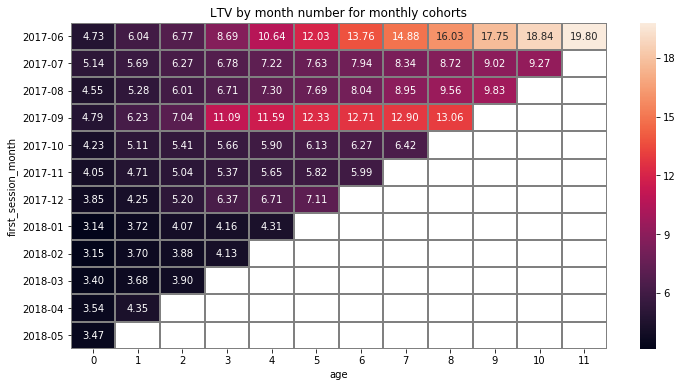

The total amount of money each cohort brought on average over their lifetime:


ltv       
                    count    sum
first_session_month             
2017-06-01           12    19.80
2017-07-01           11    9.27 
2017-08-01           10    9.83 
2017-09-01           9     13.06
2017-10-01           8     6.42 
2017-11-01           7     5.99 
2017-12-01           6     7.11 
2018-01-01           5     4.31 
2018-02-01           4     4.13 
2018-03-01           3     3.90 
2018-04-01           2     4.35 
2018-05-01           1     3.47

In [86]:
#Let's evaluete how much money users bring
#calculating the month number
orders['age'] = (orders.order_month - orders.first_session_month)/np.timedelta64(1,'M')
orders['age'] = orders.age.round().astype(int)

#calculating the number of depositor
buyers_number = conversions.groupby('first_order_month').user_id.nunique()
buyers_number.name = 'n_buyers'

#function to calculate lifetime value for cohorts
def get_cohort_ltv_report(data, margin_rate = 1.0):
    #calculating total revenue for monthly cohorts by month number
    report = data.groupby(['first_session_month', 'age']).agg({'revenue': 'sum'}).reset_index() 
    report = report.merge(buyers_number.reset_index(), left_on='first_session_month', right_on='first_order_month')
    #calculating the LTV
    report['ltv'] = margin_rate * report.revenue / report.n_buyers 
    return report

#function to visualize the cohorts as a pivot table
def plot_cohort_ltv_heatmap(report):
    plt.figure(figsize=(12, 6)) 
    plt.title('LTV by month number for monthly cohorts')
    report_pivot = report.pivot_table(index='first_session_month', columns='age', values='ltv', aggfunc='mean')\
                        .cumsum(axis=1) #v.2
    ax = sns.heatmap(report_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='gray'); 
    dates = report_pivot.reset_index()['first_session_month'].sort_values().dt.strftime('%Y-%m').unique()
    ax.set_yticklabels(labels=dates);
    plt.show()

#calculating LTV for cohorts
report = get_cohort_ltv_report(orders) 

#ploting heatmap for LTV by month number for monthly cohorts
print(BOLD + 'The total amount of money each cohort brought per month on average by making purchases:' + END) 
plot_cohort_ltv_heatmap(report)

#calculating statistics of LTV for cohorts
print(BOLD + 'The total amount of money each cohort brought on average over their lifetime:' + END)
display(report.groupby('first_session_month').agg({'ltv':['count', 'sum']}).round(2))

*If we consider the total amount of money users brought by months over a year, then the first cohort is distinguished throughout the year. We can distinguish the September cohort as well. In the third month of life, the LTV value is quite high, possibly due to the anomalous revenue value for users from this cohort in December.*

*Thus, each users from the first cohort brought \\$19.8 in revenue on average over their 12-months liftetime. And each users from the September cohort brought \\$13.1 in revenue on average over their 9-months liftetime. We considered LTV as a cohort's cumulative revenue, accounting for the number of people in the cohort, but did not take into account the profitability of the service. If we assume a margin rate of 50%, then the LTV values will be halved.*

The total amount of money each cohort brought per month on average:
Rem: Exclude revenue more than $2500


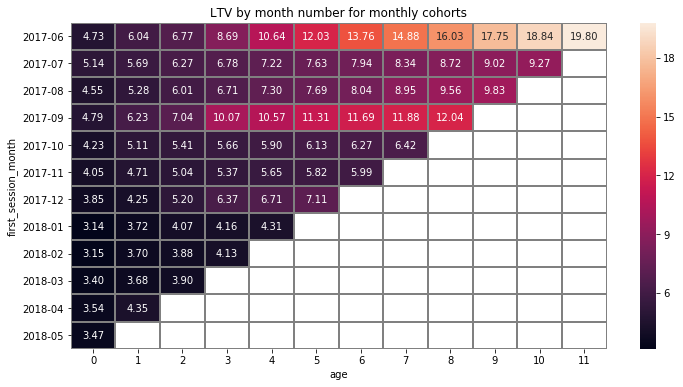

In [37]:
#Let's look at how an abnormal 'revenue' value of more than $2.5 thousand affects LTV.
print(BOLD + 'The total amount of money each cohort brought per month on average:' + END)
print(BOLD + 'Rem: ' + END + 'Exclude revenue more than $2500') 
plot_cohort_ltv_heatmap(get_cohort_ltv_report(orders[orders.revenue<2500]))

*In the third month of the September cohort's life, the LTV value do indeed change by 25% due to the huge value of 'revenue' feature.*

The total amount of money each source brought per month on average:


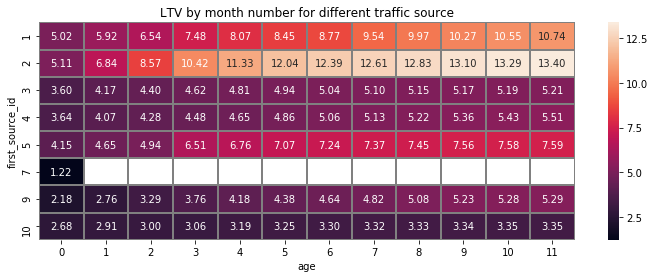

The total amount of money each source brought on average over a year:


ltv       
                count    sum
first_source_id             
1                12    10.74
2                12    13.40
3                12    5.21 
4                12    5.51 
5                12    7.59 
7                1     1.22 
9                12    5.29 
10               12    3.35

In [38]:
#Let's evaluate how much money users from different sources brought
#calculating the number of depositor by source
buyers_number_by_source = conversions.groupby('first_source_id').user_id.nunique()
buyers_number_by_source.name = 'n_buyers'

def get_ltv_report_by_source(data, margin_rate = 1.0):
    #calculating total revenue for monthly cohorts by month number
    report = data.groupby(['first_source_id', 'age']).agg({'revenue': 'sum'}).reset_index() 
    report = report.merge(buyers_number_by_source.reset_index(), on='first_source_id')
    #calculating the LTV
    report['ltv'] = margin_rate * report.revenue / report.n_buyers 
    return report

#calculating total revenue from different sources by month number
report_by_source = get_ltv_report_by_source(orders)

#ploting heatmap for LTV by month number for different sources
report_pivot_by_source = report_by_source.pivot_table(index='first_source_id', columns='age',
                                  values='ltv', aggfunc='mean')\
                            .cumsum(axis=1) #v.2
print(BOLD + 'The total amount of money each source brought per month on average:' + END) 
plt.figure(figsize=(12, 4)) 
plt.title('LTV by month number for different traffic source') 
sns.heatmap(report_pivot_by_source, annot=True, fmt='.2f', linewidths=1, linecolor='gray');
plt.show()

print(BOLD + 'The total amount of money each source brought on average over a year:' + END)
display(report_by_source.groupby('first_source_id').agg({'ltv':['count', 'sum']}).round(2))

*If we consider the total amount of money is brought by users from different sources by months for a year, then the sources 2 is distinguished. For most months of life, the LTV for these sources is greater than for other ones. We can distinguish sources 1 and 5 as well.*

*Thus, each users from the source 2 brought \\$13.4 in revenue on average over their 12-months liftetime. 
And each users from the source 1 brought \\$10.7 in revenue on average over their 12-months liftetime. The margin  rate also does not take into account due to the lack of its exact value.*

### 2.3 Marketing metrics
<a id='section2.3'></a>

#### 2.3.1 Daily, weekly and monthly marketing expenses

The dynamics of daily, weekly and monthly expenses:


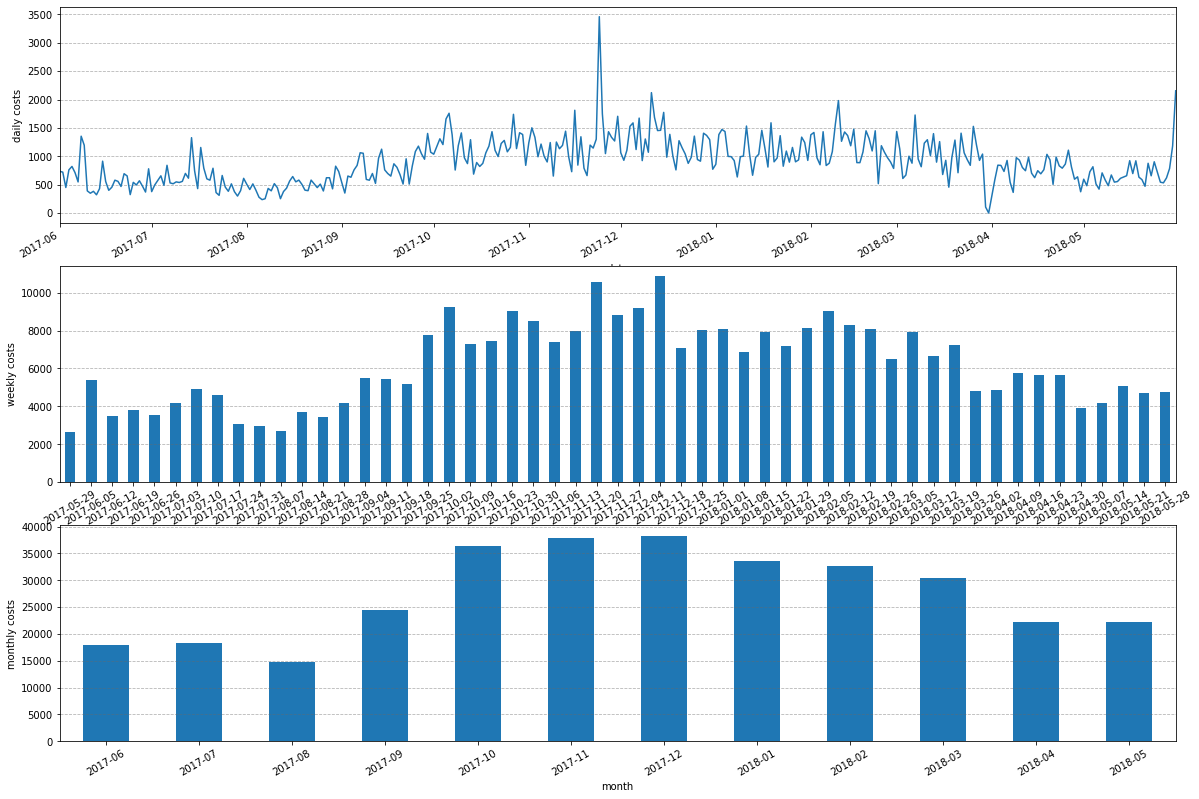

Describtive statistics for daily costs


,count,mean,std,min,25%,50%,75%,max
costs,364.0,904.21,396.96,0.7,595.68,873.66,1155.6,3458.86


Describtive statistics for weekly costs


,count,mean,std,min,25%,50%,75%,max
costs,53.0,6210.03,2144.18,2668.46,4592.82,5767.09,7958.02,10861.58


Describtive statistics for monthly costs


,count,mean,std,min,25%,50%,75%,max
costs,12.0,27427.63,8405.07,14790.54,21228.35,27392.09,34219.61,38315.35


In [39]:
#Let's look at how much money was spend
#creating dates coresponding week and month(first day of week and month)
costs['week'] = get_start_of_week(costs.date) 
costs['month'] = costs.date.astype('datetime64[M]') 

#calculating daily, weekly and monthly costs
costs_series = [costs.groupby('date').costs.sum(),
                costs.groupby(costs.week.dt.date).costs.sum(),
                costs.groupby(costs.month.dt.to_period('M')).costs.sum()]
costs_descriptions = ['daily costs', 'weekly costs', 'monthly costs']

print(BOLD + "The dynamics of daily, weekly and monthly expenses:" + END) 
plot_in_col(costs_series, costs_descriptions)

#printing describtive statistics for expenses
for stat, descr in zip(costs_series, costs_descriptions):
    print('Describtive statistics for ' + BOLD + descr + END)
    display(round(pd.DataFrame(stat.describe()).T, 2))

*On average, marketing costs are \\$ 900 per day, \\$ 6K per week, and \\$ 27K per month.*

*The highest peak of expenses also occurs at the end of November 2017. Marketing costs increased 2.5 times that day. There is also a smaller peak for the last days of the dataset.*

*We can also distinguish seasonal changes in marketing spending, that repeat the pattern of active users. In summer the amount of costs is less, in autumn costs grow and again decrease closer to summer.*

Distribution of daily marketing expenses for different traffic sources:


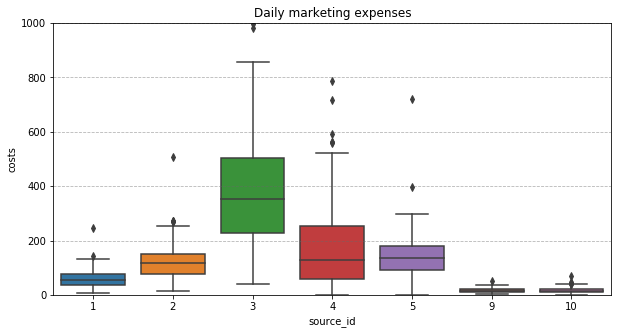

In [40]:
#Let's look at daily marketing expenses by sources
print(BOLD + 'Distribution of daily marketing expenses for different traffic sources:'+ END)
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(x='source_id', y='costs', 
            data=costs,
            ax=ax);
ax.set_title('Daily marketing expenses')
ax.grid(axis='y', linestyle='--', color='dimgray', alpha=0.5)
ax.set_ylim(0, 1000);

*Daily marketing expenses are not the same for different sources. On average, the third source requires more spending than the others.*

#### 2.3.2 CAC

In [41]:
#Let's calculate the customer acquisition cost for monthly cohorts

#function to add CAC to the report
def add_cohort_cac(report):
    monthly_costs = costs.groupby('month').costs.sum().reset_index()
    report = report.merge(monthly_costs, left_on='first_session_month', right_on='month') 
    report['cac'] = report['costs'] / report['n_buyers']  
    return report

#adding CAC to the report
report = add_cohort_cac(report)

print(BOLD + 'Customer acquisition cost in comparison with LTV for different cohorts:'+ END)
round(report.groupby(['month', 'costs', 'n_buyers', 'cac']).agg({'ltv':['sum', 'mean', 'count']}).reset_index(),2)

Customer acquisition cost in comparison with LTV for different cohorts:


month     costs n_buyers    cac    ltv            
                                           sum  mean count
0  2017-06-01  18015.00  2022     8.91   19.80  1.65  12  
1  2017-07-01  18240.59  1922     9.49   9.27   0.84  11  
2  2017-08-01  14790.54  1369     10.80  9.83   0.98  10  
3  2017-09-01  24368.91  2579     9.45   13.06  1.45  9   
4  2017-10-01  36322.88  4340     8.37   6.42   0.80  8   
5  2017-11-01  37907.88  4078     9.30   5.99   0.86  7   
6  2017-12-01  38315.35  4380     8.75   7.11   1.19  6   
7  2018-01-01  33518.52  3373     9.94   4.31   0.86  5   
8  2018-02-01  32723.03  3651     8.96   4.13   1.03  4   
9  2018-03-01  30415.27  3534     8.61   3.90   1.30  3   
10 2018-04-01  22289.38  2274     9.80   4.35   2.17  2   
11 2018-05-01  22224.27  2986     7.44   3.47   3.47  1

*It costs a company on average \\$8 to \\$10 to acquire a new user. So the investment in customer acquisition paid off for only a few cohorts. Note we don't take into account the margin rate when calculating LTV. If we assume a margin rate of 50%, then the cohorts take even longer to payback.*

In [42]:
#Let's calculate the customer acquisition cost for different traffic sources

#function to add CAC to the report
def add_cac_by_source(report):
    costs_by_source = costs.groupby('source_id').costs.sum().reset_index()
    report = report.merge(costs_by_source, left_on='first_source_id', right_on='source_id') 
    report['cac'] = report['costs'] / report['n_buyers']  
    return report

#adding CAC to the report
report_by_source = add_cac_by_source(report_by_source)

print(BOLD + 'Customer acquisition cost in comparison with LTV for different source:'+ END)
round(report_by_source.groupby(['source_id', 'costs', 'n_buyers', 'cac'])\
                          .agg({'ltv':['sum', 'mean', 'count']}).reset_index(),2)

Customer acquisition cost in comparison with LTV for different source:


source_id      costs n_buyers    cac    ltv            
                                          sum  mean count
0  1         20833.27   2896     7.19   10.74  0.89  12  
1  2         42806.04   3503     12.22  13.40  1.12  12  
2  3         141321.63  10467    13.50  5.21   0.43  12  
3  4         61073.60   10295    5.93   5.51   0.46  12  
4  5         51757.10   6931     7.47   7.59   0.63  12  
5  9         5517.49    1088     5.07   5.29   0.44  12  
6  10        5822.49    1327     4.39   3.35   0.28  12

*Attracting each user cost the company a different amount of money depending on the source and varies from \\$4.5 to \\$13.5. The investment in user acquisition paid off for 1st, 2nd, 5th and 9th sources. The margin  rate also does not take into account due to the lack of its exact value. LTV is only slightly higher than CAC. So if we take into account the profitability, then the investment in user acquisition will not pay off within a year under consideration.*

#### 2.3.3 ROMI

Cumulative return of marketing investments for monthly cohorts:


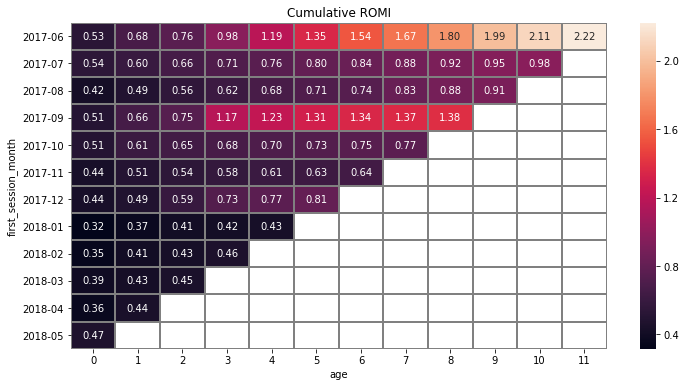

In [43]:
#Let's calculate ROMI for monthly cohorts
def add_ROMI(report):
    report['romi'] = report['ltv'] / report['cac'] 
    return report

report = add_ROMI(report)
 
def plot_cohort_ROMI_heatmap(report):
    output = report.pivot_table(index='first_session_month', columns='age',  
                    values='romi', aggfunc='mean')

    plt.figure(figsize=(12, 6)) 
    plt.title('ROMI') 
    ax = sns.heatmap(output, annot=True, fmt='.2f', linewidths=1, linecolor='gray'); 
    dates = output.reset_index()['first_session_month'].sort_values().dt.strftime('%Y-%m').unique()
    ax.set_yticklabels(labels=dates);
    plt.show()

def plot_cohort_cumROMI_heatmap(report):
    output = report.pivot_table(index='first_session_month', columns='age',  
                    values='romi', aggfunc='mean')
    
    plt.figure(figsize=(12, 6)) 
    plt.title('Cumulative ROMI') 
    ax = sns.heatmap(output.cumsum(axis=1), annot=True, fmt='.2f', linewidths=1, linecolor='gray'); 
    ax.set_yticklabels(labels=dates);
    plt.show()
    
#print(BOLD + 'Return of marketing investments for monthly cohorts:' + END) 
#plot_cohort_ROMI_heatmap(report)
print(BOLD + 'Cumulative return of marketing investments for monthly cohorts:' + END) 
plot_cohort_cumROMI_heatmap(report)

*The June cohort paid off in 5th months (ROMI = 1.19) and the September cohort paid off in 4th months (ROMI=1.17).  Note the margin rate does not take into account.*

Cumulative return of marketing investments for monthly cohorts, margin rate = 0.5:


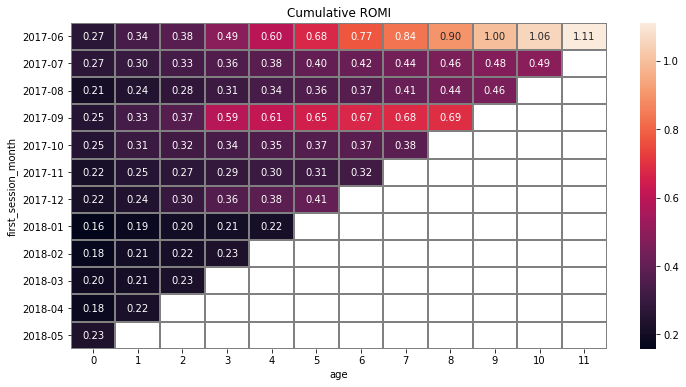

In [44]:
#Let's consider the 50% margin rate
print(BOLD + 'Cumulative return of marketing investments for monthly cohorts, margin rate = 0.5:' + END) 
plot_cohort_cumROMI_heatmap(add_ROMI(add_cohort_cac(get_cohort_ltv_report(orders, .5))))

*If we consider a margin of 50%, only the June cohort paid off in 10th months (ROMI = 1.0).*

Cumulative return of marketing investments by sources:


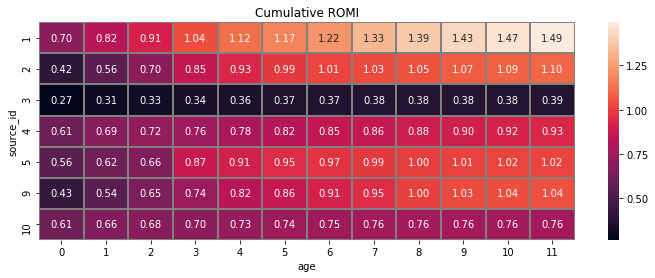

In [45]:
#Let's calculate ROMI for different traffic sources
report_by_source = add_ROMI(report_by_source)

output_by_source = report_by_source.pivot_table(index='source_id', columns='age',  
                    values='romi', aggfunc='mean')

#print(BOLD + 'Return of marketing investments by sources:' + END) 
#plt.figure(figsize=(12, 4)) 
#plt.title('ROMI') 
#ax = sns.heatmap(output_by_source, annot=True, fmt='.2f', linewidths=1, linecolor='gray'); 
#plt.show()

print(BOLD + 'Cumulative return of marketing investments by sources:' + END)
plt.figure(figsize=(12, 4)) 
plt.title('Cumulative ROMI') 
ax = sns.heatmap(output_by_source.cumsum(axis=1), annot=True, fmt='.2f', linewidths=1, linecolor='gray'); 
plt.show()

*The investment in acquisition users from the 1st source pays off in 4 months (ROMI=1.04), from the 2nd source do in 7th months, and from 5th and 9th source do in 9 months.*

In [46]:
#Let's look at what customer acquisition should be in order for marketing investments to pay off in the first 6 months 
print(BOLD + 'Average LTV for 6 months from the first order:' + END) 
display(report_by_source.pivot_table(index='first_source_id', columns='age', values='ltv', aggfunc='mean')\
    .cumsum(axis=1)[5].reset_index())

Average LTV for 6 months from the first order:


,first_source_id,5
0,1,8.452200
1,2,12.039829
2,3,4.939761
3,4,4.859177
4,5,7.070283
5,9,4.383419
6,10,3.250859


*For marketing investments to pay off, one customer acquisition should cost different values for different sources. Thus, we have a larger playroom for the first 2 sources than for the last one.*

### Conclusions
<a id='section2.4'></a>

__Product metrics__

The site has an average of 900 users every day, 600 of whom visit the site for the first time.

Sticky factors are quite low. So users who visit the site every day for a week or a month have very little overlap and we have 5,700 unique users per week, and 23,000 unique users per month. Thus, 80% of users visited the site only once and have never come back. 40% of the loyal users came back to the site within the next month. The rest of the loyal users returned a second time after a fairly long period of time over the year. Only about 10% of loyal users come back the next day.

On average, each user spends at most 1 session on the service per day. The average session length is about 10 minutes. The most popular session duration is one minute (more than 14% of all sessions). And 10% of all sessions last less than a minute.

__Sales metrics__

Users make about 140 purchases per day, on average. The average purchase per day is about \$5.
The majority of users make a purchase on their first visit to the site. Thus, users visit the site to buy a ticket. Although some users visit the site to buy a ticket a lot after the first visit to the site.

__Marketing metrics__

The average marketing costs are \\$900 per day. Each paying user costs the company an average of \\$8 to \$10 to acquire.

__Special data properties__

We can notice seasonal changes in the number of active users and, accordingly, the number of their purchases. In summer, the number of active users is less, in autumn their number grows and decreases again closer to summer. Seasonal changes in marketing spending repeat the pattern of active users.

You can also notice 2 peaks in the data occurring at the end of November (large one) and at the end of May (smaller one). The number of active users and the number of their purchases has significantly increased, the average duration of their session has slightly increased. Marketing costs also increased during these 2 days. It could have been related to some kind of promotion. There was also a sharp drop in these indicators at the end of March, most likely due to some problems on the site. It makes sense to find out what happened that day.


__Cohort analysis__

If we consider the behavior of users acquired in different months of the year under consideration, then the behavior for some of them will be different. 
* The June cohort stands out strongly. Users of this cohort have higher retention and conversion rates during the entire period under consideration. They did not make as many purchases in the first month as some of the other cohorts, but they did more purchases in the remaining months than the rest of the cohorts. Each user from the June cohort generated more revenue on average than a user from the other cohorts. Their LTV is almost always higher for each month of life. The investment in customer acquisition paid off in 5th months for this cohort (without taking into account the margin rate).
* September cohort users have high retention rates during the first 4 months. Each user from the September cohort generated the highest revenue on average during 5 months. Their LTV is almost always higher for the 5 first months. The investment in customer acquisition paid off in 4th months for this cohort (without taking into account the margin rate).
* Users from the October cohort made the maximum number of purchases within the first month. They have relatively high retention during the first 3 months. Their conversion is higher than the conversion of most cohorts. But the cost of acquisition them did not pay off in 8 months.
* The November cohort users have the highest retention rate during the first weeks. With the October cohort, they have the largest number of purchases during the first month. The acquisition costs of these users did not pay off in 7 months.


__Ad sources analysis__

If we consider the behavior of users acquired by different ad sources, then the behavior of some of them will also stand out.
* Ad source 1 acquired an average of 80 users per day. Some users from this cource revisit the site during the day. This might be the case for search traffic or retargeting campaigns. 30% of users who came from sources 1 come back to the site. These users have the highest retention rates during the first week and remain it high for a couple of months. Each user from Source 1 generated the second highest LTV on average in the first month and also for the entire 12 months. On average, daily marketing spending for this source was one of the lowest. The investment in acquisition users pays off in 4 months.
* Ad source 2 acquired an average of 120 users per day. Some users from this source also revisit the site during the day. Almost 30% of users who came from sources 2 come back to the site. These users have the highest retention rates during the first week and remain it high for a couple of months. These users have relatively high retention rates during the first week and remain high for several months. Each user from Source 2 generated the highest LTV on average in the first month and also for the entire 12 months. The investment in acquisition users from the 2st source pays off in 7 months. 
* Ad source 3 acquired an average of 230 users per day. 20% of users who came from sources 3 come back to the site. Users from this source made the maximum number of purchases within the first month. On average, the 3rd source requires more spending than the others. The acquisition costs of users for this cource did not pay off during a year. ROMI after 12 months is very low, only 0.39.
* Ad source 4 acquired an average of almost 300 users per day. Just over 15% of users who come from source 4 return to the site. Users from this source made the second lagest number of purchases within the first month.The acquisition costs of users for this cource did not pay off during a year.
* Ad source 5 acquired an average of almost 170 users per day. 15% of users who came from sources 5 come back to the site.  The investment in acquisition users from the 5th source pays off in 9 months.
* There are not enough data for sources 6 and 7.
* Ad source 9 acquired an average of 20-30 users per day. 35% of users who came from sources 9 come back to the site. These users have the highest retention rates during the first month and remain it high for several months. For some users, the conversion is quite late. Perhaps these purchases occur after mailing or using other ways to maintain user loyalty using CRM. For the 9th source daily marketing expenses were lower than the others. The investment in acquisition users from the 9th source pays off in 9 months.
* Ad source 10 acquired an average of 20 users per day. Just over 15% of users who come from source 10 return to the site. For the 9th source daily marketing expenses were lower than the others. The acquisition costs of users for this cource did not pay off during a year.

## 3. Marketing investment recommendations
<a id='section3'></a>

We have 7 different traffic sources among which we can distribute our investments. 

According to the ROMI the best source is the source 1. It makes sense to try scaling the source. If only the budget limit prevents us from spending more, we could probably scale the source without any impact on ROMI. If ROMI changes, then scaling will end up with increase of CAC, but we still have enough playroom since users have high retention rates remaining for several months and LTV remains relatively high during a given period of time. 

Source 2, 5, 9 are the second best options to invest in. There is a need to optimize the campaigns there. We could target ROMI more than 1 for 6 months age. For marketing investments to pay off for this period, one customer acquisition should not cost more than \\$12, \\$7 and \\$4.4 accordingly for these sources. First of all, we should pay attention to sources 2 and 9, since they have high retention for several month. The fact that users are still returning to the site and making purchases allows us to pay off our investment. Moreover, each user from source 2 generated the highest LTV on average in the first month as well as for the entire 12 months. So the 2nd source might be the second best choice to invest in.

Cutting costs at sources 3, 4, 10 is needed. It's required to limit the spend there and optimizing the campaigns. For marketing investments to pay off in 6 months, one customer acquisition should not cost more than \\$5, \\$7 and \\$3 accordingly for these sources. They bring in a lot of new users, so we need to think about returning that customers as well.